In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=7
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
# needs treshold  3 QuatreCamins, 2 SantBoi,  7 Mollet 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  4929.808641975347
Friday area:  4763.91666666666
Weekend area:  1473.9833333333395
Weekday maximum:  205.07407407407408
Friday maximum:  198.16666666666666
Weekend maximum:  65.1


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

#parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if not(bolTrainagain):
    try:
        with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
            [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
             errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
            f.close()
    except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
        print('no saved data: recalcualting')
        bolTrainagain = True

if bolTrainagain:
    errors_wd = np.ones(np.shape(training_weekdays_norm))

    parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*wd_length)

    optimal_params_weekdaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_weekdays_norm,training_weekdays_isfull,errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


In [5]:
var_weekdaytn_time = np.mean(errors_wd)
#var_weekdaytn = optimal_params_weekdaytn.fun/np.size(training_weekdays_norm)
stdv_weekdaytn=math.sqrt(var_weekdaytn_time)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.08306



In [6]:
optimal_params_weekdaytn

 final_simplex: (array([[0.295757  , 0.03638965, 0.79166579, 0.09411074, 0.79186614,
        0.91784199, 0.65629138, 1.02015911, 1.02648629, 0.92167831,
        0.76769668, 0.88661944, 0.90533556, 0.90984115, 0.73983651,
        0.89479434, 0.71671067, 0.76082157, 0.69406616, 0.80340711,
        0.74911726, 0.74911726, 0.74911679, 0.68829755, 1.06779299,
        0.70322416, 0.8828807 , 0.67706835, 0.55308513, 0.84168545,
        0.70249286],
       [0.295757  , 0.03638965, 0.79166579, 0.09411074, 0.79186615,
        0.917842  , 0.65629134, 1.02015911, 1.02648625, 0.92167816,
        0.76769635, 0.88661942, 0.90533556, 0.90984115, 0.73983659,
        0.89479456, 0.71671083, 0.7608215 , 0.69406613, 0.80340703,
        0.74911739, 0.74911739, 0.74911692, 0.68829767, 1.06779301,
        0.70322422, 0.88288084, 0.67706807, 0.553085  , 0.84168543,
        0.70249297],
       [0.29575699, 0.03638965, 0.79166579, 0.09411074, 0.79186617,
        0.91784202, 0.65629131, 1.02015912, 1.02648625, 0

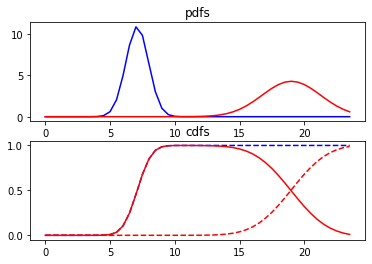

In [7]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [8]:
optimal_params_weekdayth=np.mean(optimal_params_weekdaytn.x[4:])

In [9]:
optimal_params_weekdayth

0.806567810682275

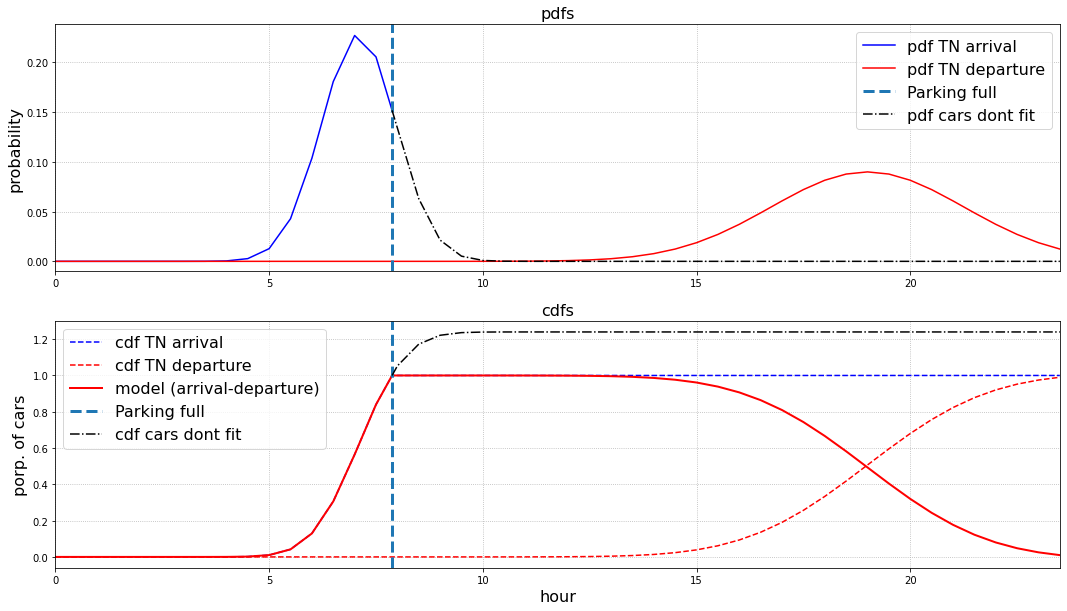

In [10]:
fid=plot_model_tn_thDisc(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],
              optimal_params_weekdaytn.x[3],optimal_params_weekdayth)
fid.savefig('Model_'+current_parking+'.pdf',bbox_inches='tight');

In [11]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.295757  , 0.03638965, 0.79166579, 0.09411074, 0.79186614,
       0.91784199, 0.65629138, 1.02015911, 1.02648629, 0.92167831,
       0.76769668, 0.88661944, 0.90533556, 0.90984115, 0.73983651,
       0.89479434, 0.71671067, 0.76082157, 0.69406616, 0.80340711,
       0.74911726, 0.74911726, 0.74911679, 0.68829755, 1.06779299,
       0.70322416, 0.8828807 , 0.67706835, 0.55308513, 0.84168545,
       0.70249286])

In [12]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
prototype_math_arr_weekday=cdf1_wd
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
prototype_math_dep_weekday=cdf2_wd
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd#/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")
#plt.plot(time2, cdf1_wd_ap, label="Cummulative probability arrival approx")
#plt.plot(time2, cdf2_wd_ap, label="Cummulative probability departure approx")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


In [13]:
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])

ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdayth)
t_parking_full=np.interp(optimal_params_weekdayth,cdf1_wd,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)

tn1_wd_unmodifed=tn1_wd
tn1_wd=np.insert(tn1_wd,ix_parking_full,np.interp(t_parking_full,time2,tn1_wd))
tn1_wd_excees=tn1_wd.copy()
tn1_wd[ix_parking_full+1:] =0
tn1_wd_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_wd), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_wd), dtype=bool)
masktn1_excees[:ix_parking_full] =False

#tn1_wd[cdf1_wd>optimal_params_weekdayth] =0
#tn1_wd_excees[cdf1_wd<optimal_params_weekdayth] =0
cdf1_wd[cdf1_wd>optimal_params_weekdayth] = optimal_params_weekdayth
cdf1_wd_plot=np.insert(cdf1_wd,ix_parking_full,optimal_params_weekdayth)

cdf1_wd = cdf1_wd/optimal_params_weekdayth
cdf1_wd_plot = cdf1_wd_plot/optimal_params_weekdayth

cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
cdf2_wd_plot=np.insert(cdf2_wd,ix_parking_full,np.interp(t_parking_full,time2,cdf2_wd))
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
resta_wd_plot = np.array(cdf1_wd_plot) - np.array(cdf2_wd_plot)
prototype_math_weekday = resta_wd#/sum(resta_wd)
prototype_math_weekday_plot = resta_wd_plot#/sum(resta_wd)
#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2_th[masktn1], tn1_wd[masktn1]/sum(tn1_wd_unmodifed), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2_th, cdf1_wd_plot, label="Cummulative probability arrival")
#plt.plot(time2_th, cdf2_wd_plot, label="Cummulative probability departure")

#plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2_th[masktn1_excees], tn1_wd_excees[masktn1_excees]/sum(tn1_wd_unmodifed),'-.',
#         label="Excess Probability")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");

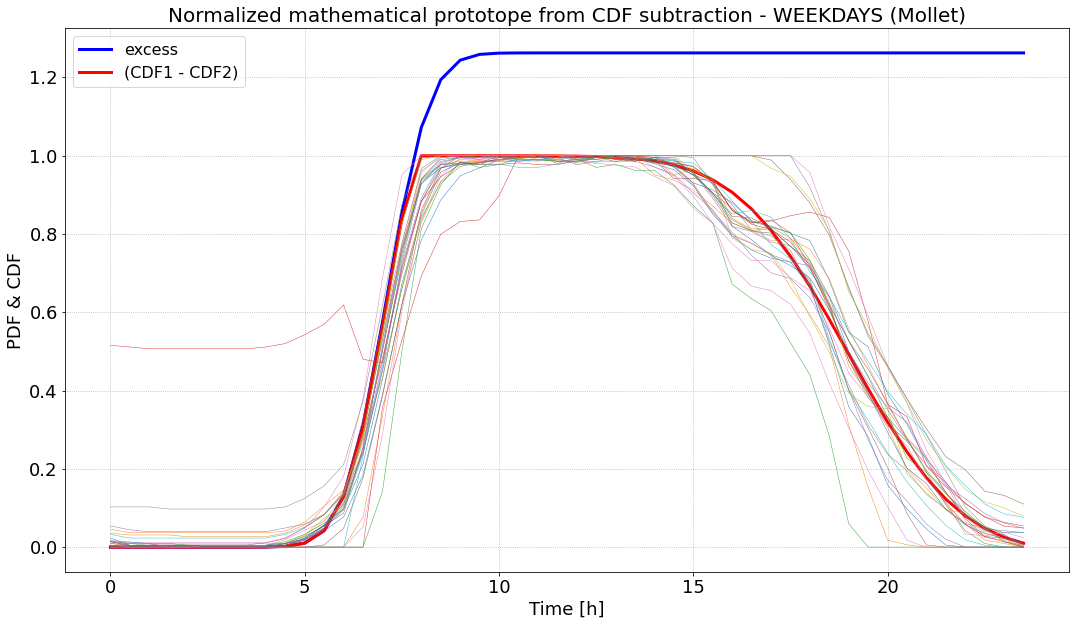

In [14]:
fig = plt.figure(figsize=(18,10))
plt.title("Normalized mathematical prototope from CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time2, prototype_math_arr_weekday/optimal_params_weekdaytn.x[4], linewidth=3, color='blue', label="excess")
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    plt.plot(time, training_weekdays_norm[i], linewidth=0.45)

plt.legend(fontsize=16, loc="upper left");

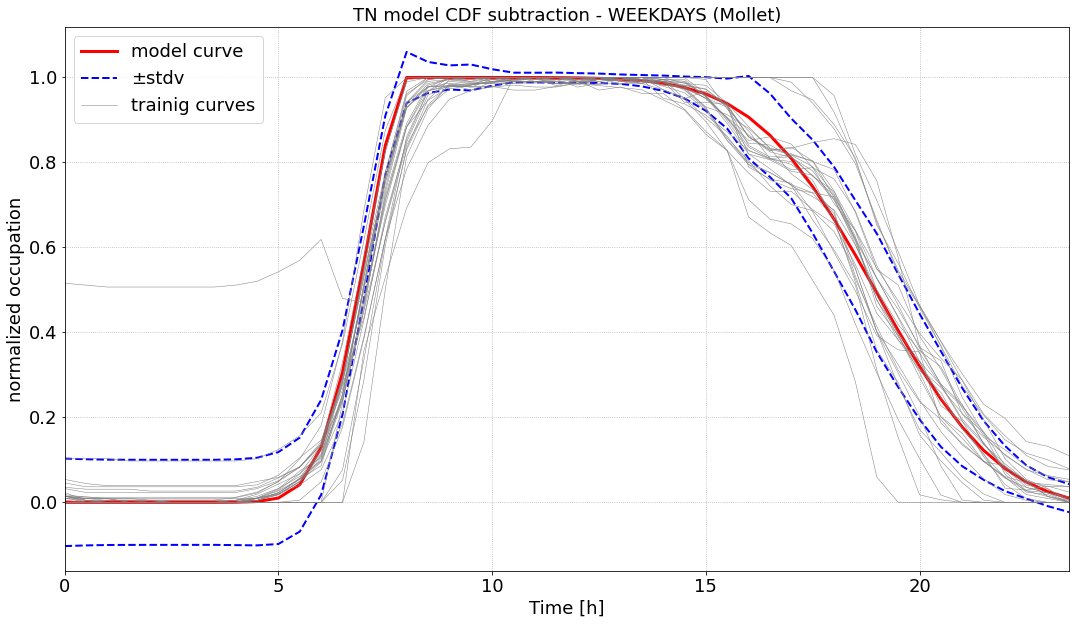

In [15]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

In [16]:
bol_plot_individual_fits = False
if bol_plot_individual_fits: 
    tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
    tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    for ii in range(0,len(training_weekdays_norm)):
        idx_th=ii+4

        cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])


        dayisFull=training_weekdays_isfull[ii]
        if dayisFull:
            print(optimal_params_weekdaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] =0
            cdf1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] = optimal_params_weekdaytn.x[idx_th]
            cdf1_wd = cdf1_wd/optimal_params_weekdaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
        prototype_math_weekday = resta_wd#/sum(resta_wd)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - weekdayS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_weekdays_norm)):
        plt.plot(time, training_weekdays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### FRIDAYS

In [17]:
if bolTrainagain:
    errors_fr = np.ones(np.shape(training_fridays_norm))

    parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*f_length)
    optimal_params_fridaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_fridays_norm,training_fridays_isfull,errors_fr),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})



In [18]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
#print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.14944



In [19]:
optimal_params_fridaytn

 final_simplex: (array([[0.30577551, 0.03871341, 0.81122301, 0.17153119, 0.88433931,
        0.75313584, 0.82026323, 0.54323612, 0.67382288, 0.67382288],
       [0.3057755 , 0.0387134 , 0.81122309, 0.17153123, 0.88433929,
        0.75313571, 0.82026281, 0.54323609, 0.67382311, 0.67382311],
       [0.30577551, 0.03871339, 0.81122308, 0.1715313 , 0.88433926,
        0.75313609, 0.82026298, 0.54323611, 0.67382275, 0.67382275],
       [0.30577549, 0.0387134 , 0.811223  , 0.17153121, 0.88433937,
        0.75313559, 0.82026271, 0.54323628, 0.67382346, 0.67382346],
       [0.30577552, 0.03871342, 0.81122294, 0.17153112, 0.88433933,
        0.75313566, 0.82026327, 0.54323615, 0.67382302, 0.67382302],
       [0.30577552, 0.03871341, 0.81122306, 0.17153129, 0.88433909,
        0.75313584, 0.82026253, 0.54323599, 0.67382296, 0.67382296],
       [0.30577551, 0.03871339, 0.81122307, 0.17153128, 0.88433925,
        0.75313582, 0.82026258, 0.54323615, 0.67382312, 0.67382312],
       [0.30577551, 0.03

In [20]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [21]:
optimal_params_fridaytn.x[4:]

array([0.88433931, 0.75313584, 0.82026323, 0.54323612, 0.67382288,
       0.67382288])

In [22]:
optimal_params_fridayth=np.mean(optimal_params_fridaytn.x[4:])

In [23]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta#/sum(resta)
#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

In [24]:
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
prototype_math_arr_friday=cdf1_fri.copy()

ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridayth)
t_parking_full=np.interp(optimal_params_fridayth,cdf1_fri,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)


tn1_fri_unmodifed=tn1_fri
tn1_fri=np.insert(tn1_fri,ix_parking_full,np.interp(t_parking_full,time2,tn1_fri))
tn1_fri_excees=tn1_fri.copy()
tn1_fri[ix_parking_full+1:] =0
tn1_fri_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_fri), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_fri), dtype=bool)
masktn1_excees[:ix_parking_full] =False

cdf1_fri[cdf1_fri>optimal_params_fridayth] = optimal_params_fridayth
cdf1_fri_plot=np.insert(cdf1_fri,ix_parking_full,optimal_params_fridayth)

cdf1_fri = cdf1_fri/optimal_params_fridayth
cdf1_fri_plot = cdf1_fri_plot/optimal_params_fridayth

cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])
cdf2_fri_plot=np.insert(cdf2_fri,ix_parking_full,np.interp(t_parking_full,time2,cdf2_fri))
prototype_math_dep_friday=cdf2_fri
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
resta_fri_plot = np.array(cdf1_fri_plot) - np.array(cdf2_fri_plot)
prototype_math_friday = resta_fri#/sum(resta_wd)
prototype_math_friday_plot = resta_fri_plot

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)

#plt.plot(time2_th[masktn1], tn1_fri[masktn1]/sum(tn1_fri_unmodifed), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.plot(time2_th, cdf1_fri_plot, label="Cummulative probability arrival")
#plt.plot(time2_th, cdf2_fri_plot, label="Cummulative probability departure")
#plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2_th[masktn1_excees], tn1_fri_excees[masktn1_excees]/sum(tn1_fri_unmodifed),'-.',
#         label="Excess Probability")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");

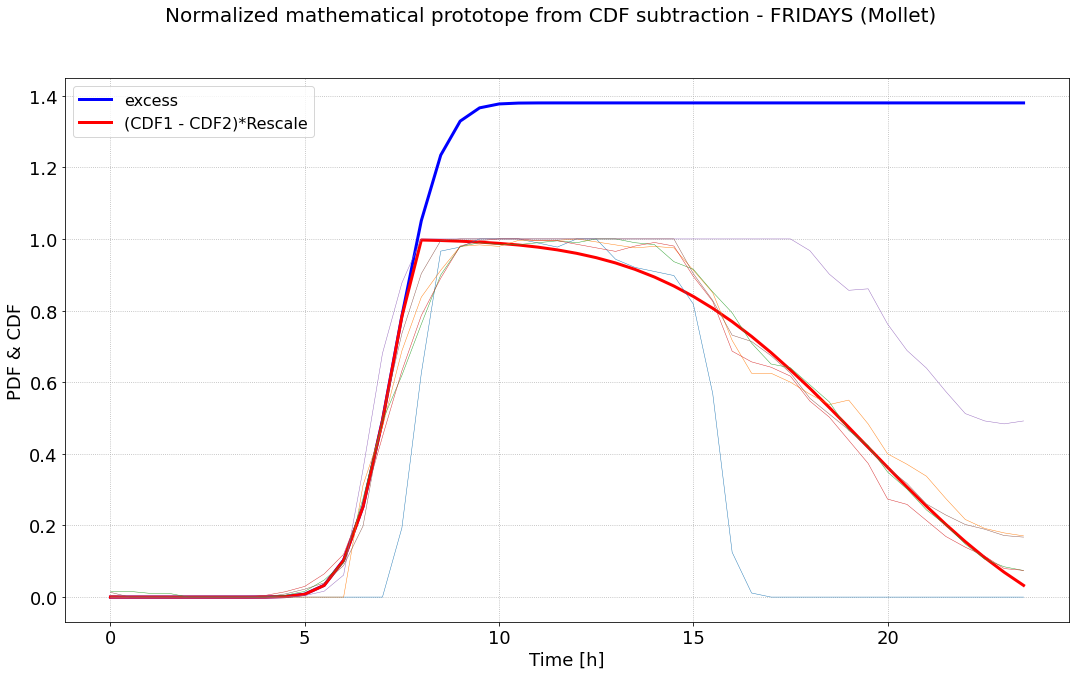

In [25]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time, prototype_math_arr_friday/optimal_params_fridayth, linewidth=3, color='blue', label="excess")
plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
for i in range(0,len(training_fridays_norm)):
    plt.plot(time, training_fridays_norm[i], linewidth=0.45)
plt.legend(fontsize=16);

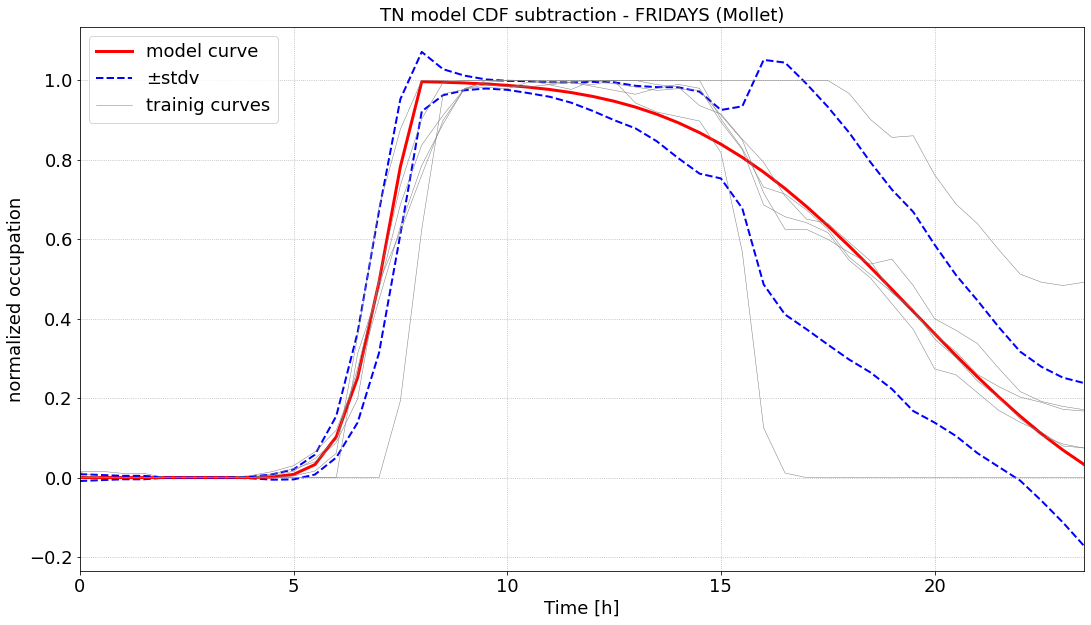

In [26]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

In [27]:
bol_plot_individual_fits = False
if bol_plot_individual_fits:
    tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
    tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    for ii in range(0,len(training_fridays_norm)):
        idx_th=ii+4

        cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])


        dayisFull=training_fridays_isfull[ii]
        if dayisFull:
            print(optimal_params_fridaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] =0
            cdf1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] = optimal_params_fridaytn.x[idx_th]
            cdf1_fri = cdf1_fri/optimal_params_fridaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
        prototype_math_friday = resta_fri#/sum(resta_fri)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_fridays_norm)):
        plt.plot(time, training_fridays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### WEEKENDS

In [28]:
parameters_tn = np.array([.2 ,.05,.7,.1])
if bolTrainagain:
    errors_we = np.ones(np.shape(training_weekends_norm))  
    if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
        optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors_we),
                                    method='SLSQP',
                                    bounds=((0, None), (0, None),(0, None),(0, None)),
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
    else:
        optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors_we),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


In [29]:
if bolTrainagain:
    #save modelparams and error
    with open('data/'+current_parking+'_modelFitTH.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we], f)
        f.close()
    
    # Getting back the objects:
    with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [30]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.17170



In [31]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([3.80635202e-01, 1.49301088e-01, 2.06314851e+04, 5.46645109e+01])

In [32]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we#/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

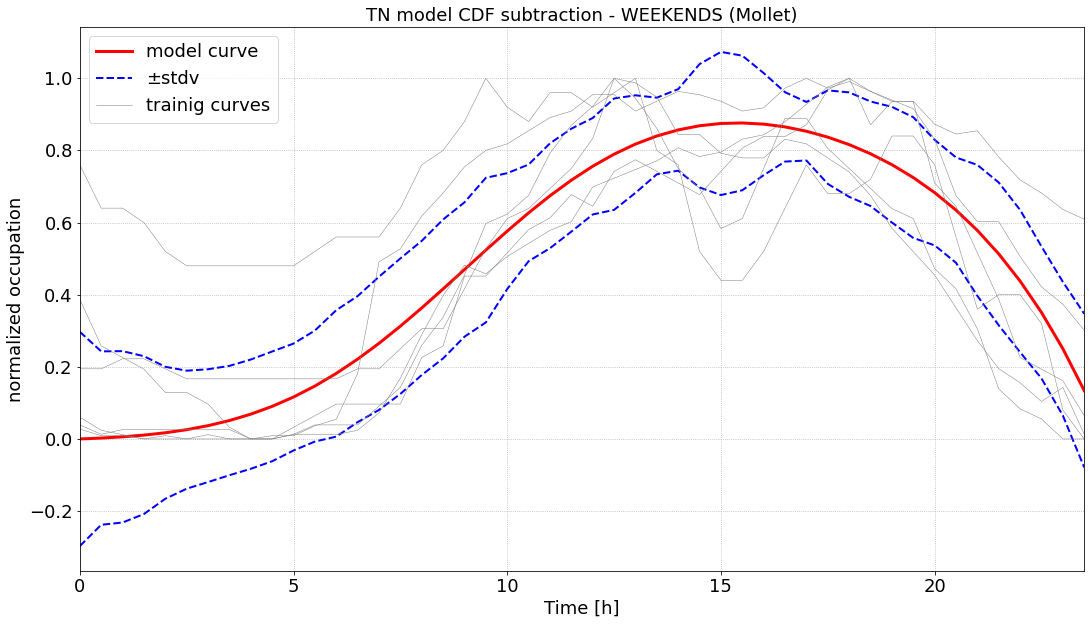

In [33]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [34]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS Mollet -----------
Mean Arrival Time   = 07:05h
stdv Arrival        =  0:52h
Mean Departure Time = 18:59h
stdv Departure      =  2:15h
Parking full        = 08:00h
--------- FRIDAYS Mollet -----------
Mean Arrival Time   = 07:20h
stdv Arrival        =  0:55h
Mean Departure Time = 19:28h
stdv Departure      =  4:07h
Parking full        = 08:00h
--------- WEEKENDS Mollet -----------
Mean Arrival Time   = 09:08h
stdv Arrival        =  3:34h
Mean Departure Time = 495155:38h
stdv Departure      = 1311:56h


In [35]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

tn_arr_weekday_n = prototype_math_arr_weekday
tn_dep_weekday_n = prototype_math_dep_weekday
tn_arr_friday_n = prototype_math_arr_friday
tn_dep_friday_n = prototype_math_dep_friday

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [36]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_max + weekday_offset
tn_arr_weekday = tn_arr_weekday_n*weekday_max + weekday_offset

tn_weekday_nooff = tn_weekday_n*weekday_max 
tn_arr_weekday_nooff = tn_arr_weekday_n*weekday_max 
tn_dep_weekday = tn_dep_weekday_n*weekday_max #+ weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_max + friday_offset
tn_arr_friday = tn_arr_friday_n*friday_max + friday_offset

tn_friday_nooff = tn_friday_n*friday_max
tn_arr_friday_nooff = tn_arr_friday_n*friday_max
tn_dep_friday = tn_dep_friday_n*friday_max #+ friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_max + weekend_offset 

tn1_weekend_nooff = tn1_weekend_n*weekend_max 

In [37]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

35 cars could not park
30 cars could not park
23 cars could not park
44 cars could not park
13 cars could not park
33 cars could not park
20 cars could not park
29 cars could not park
______ MEAN ± STDV________
2.6584046720397243  ±  1.7758886477795681
2.686351258383965  ±  2.5806628284398108
3.1304537923571876  ±  2.5285680533087675
3.0970811914149885  ±  2.687372485247821
6.1055259132514434  ±  3.278489172129784
1.387439239704972  ±  0.8678777010001163
1.6746023096519433  ±  1.335365979732222


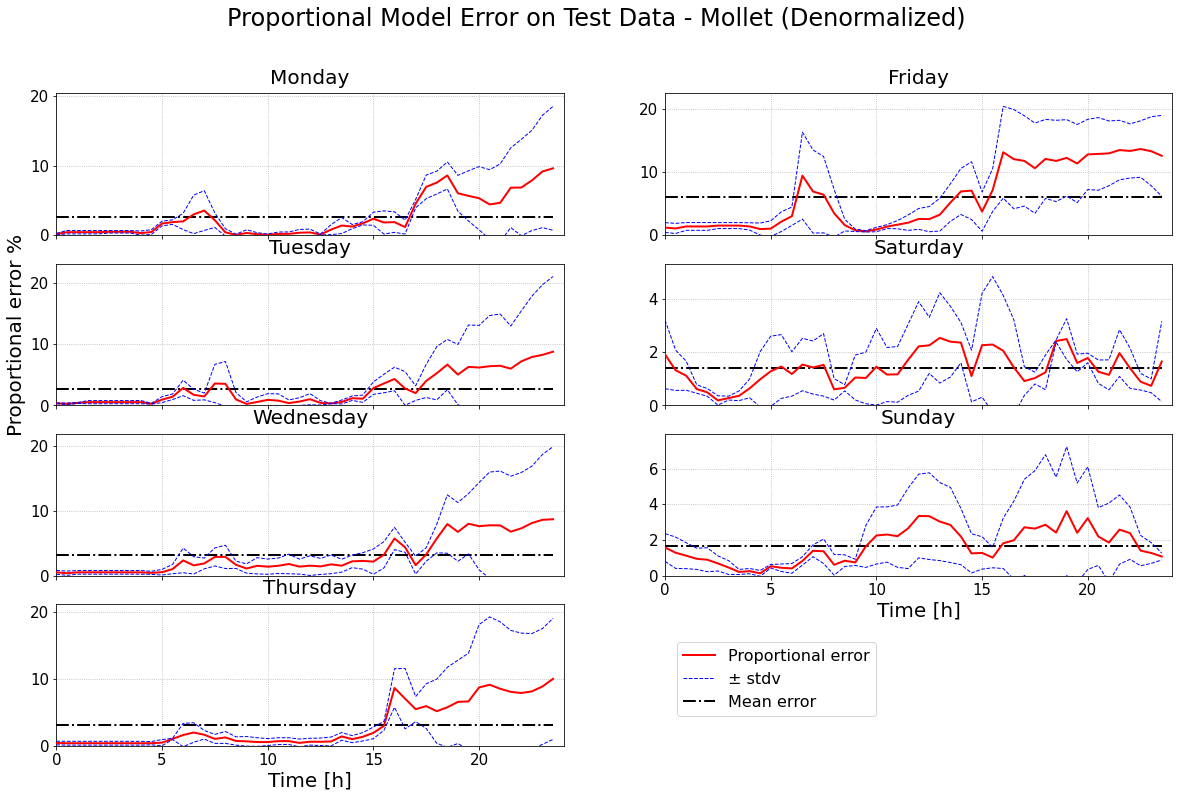

In [38]:

#[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv_fit(testing_mondays, tn_weekday, max_value)
#[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv_fit(testing_tuesdays, tn_weekday, max_value)
#[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv_fit(testing_wednesdays, tn_weekday, max_value)
#[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv_fit(testing_thursdays, tn_weekday, max_value)
#[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv_fit(testing_fridays, tn_friday, max_value)

[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_mondays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_tuesdays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_wednesdays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_thursdays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv_fitTh(testing_fridays, tn_arr_friday_nooff, tn_dep_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv_fit(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv_fit(testing_sundays, tn1_weekend, max_value)



    
fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday', 'Monday',False,False,False,False)


mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'th.pdf',bbox_inches='tight');
#ax[1,1].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))

#2.7099637370236747  ±  1.4736557849835552
#1.925942761285978  ±  0.9518195298543765
#4.466166164768858  ±  3.598647373249273
#4.958390536998728  ±  3.2336490787488423
#3.5121002753705888  ±  1.9714569641577306
#1.4446216223202166  ±  0.6038895057300911
#1.5398630128235424  ±  0.7823771802230111


#2.228801820252222  ±  1.2395925005732904
#1.609811647344771  ±  0.7446884490736162
#3.625330724308389  ±  3.1692274849228514
#4.465706101107658  ±  3.0252730281329576
#3.234686496186758  ±  1.881156554979368
#1.4446216223202166  ±  0.6038895057300911
#1.5398630128235424  ±  0.7823771802230111

In [39]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [40]:
f = open('data/'+current_parking+'_testErrorTH.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [41]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

In [42]:
def plot_prototype_fit():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        #tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
        tn_arr_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

        #scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]
        
    
        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
        
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                              scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date, current_parking)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

In [43]:
def plot_prototype_fitTH():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        #tn_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_proto, max_value)
        tn_arr_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

        #scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]
        
    
        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
        
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                              scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date, current_parking)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

#### MONDAY

In [44]:
statistic_proto = hist_weekday_proto
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 7.5
day = 'Monday'

2020-02-24
60 cars could not park
Real Monday scaled prototype error:  9.86 %
Real Monday scaled prototype error (median):  6.1 %
Real Monday scaled prototype STDV: 8.45648008619228
Real Monday scaled TN error:  18.82 %
Real Monday scaled TN error (median):  16.22 %
Real Monday scaled TN STDV:  5.7901619602320835
_____________________________________________________________
2020-03-02
9 cars could not park
Real Monday scaled prototype error:  7.1 %
Real Monday scaled prototype error (median):  6.99 %
Real Monday scaled prototype STDV: 3.362698144988134
Real Monday scaled TN error:  2.95 %
Real Monday scaled TN error (median):  2.17 %
Real Monday scaled TN STDV:  3.105912851225353
_____________________________________________________________
2020-03-09
30 cars could not park
Real Monday scaled prototype error:  8.45 %
Real Monday scaled prototype error (median):  10.16 %
Real Monday scaled prototype STDV: 3.589727365652428
Real Monday scaled TN error:  4.89 %
Real Monday scaled TN error

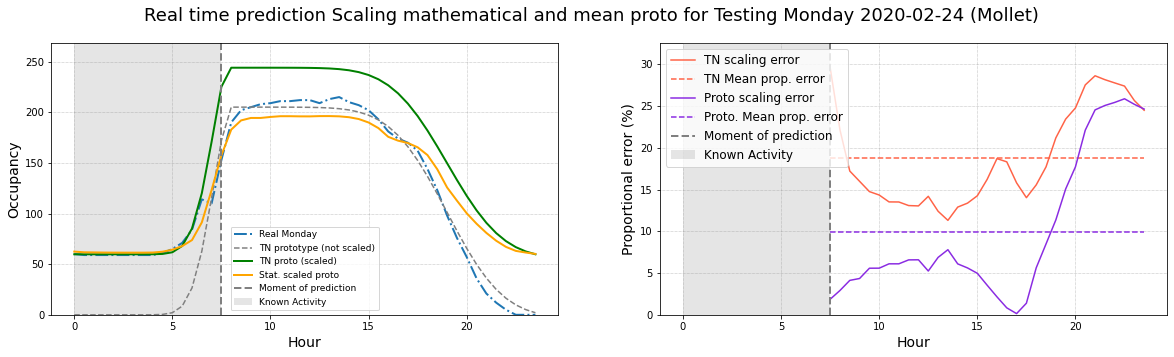

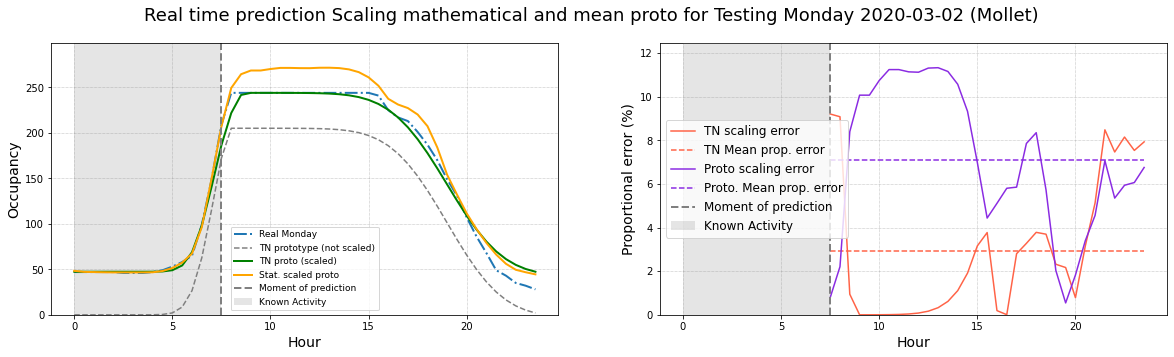

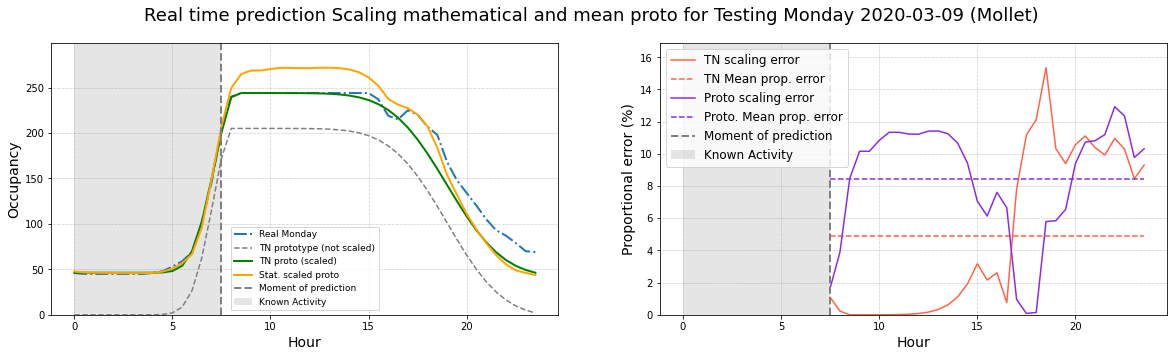

In [45]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

In [46]:
starting_hour=7

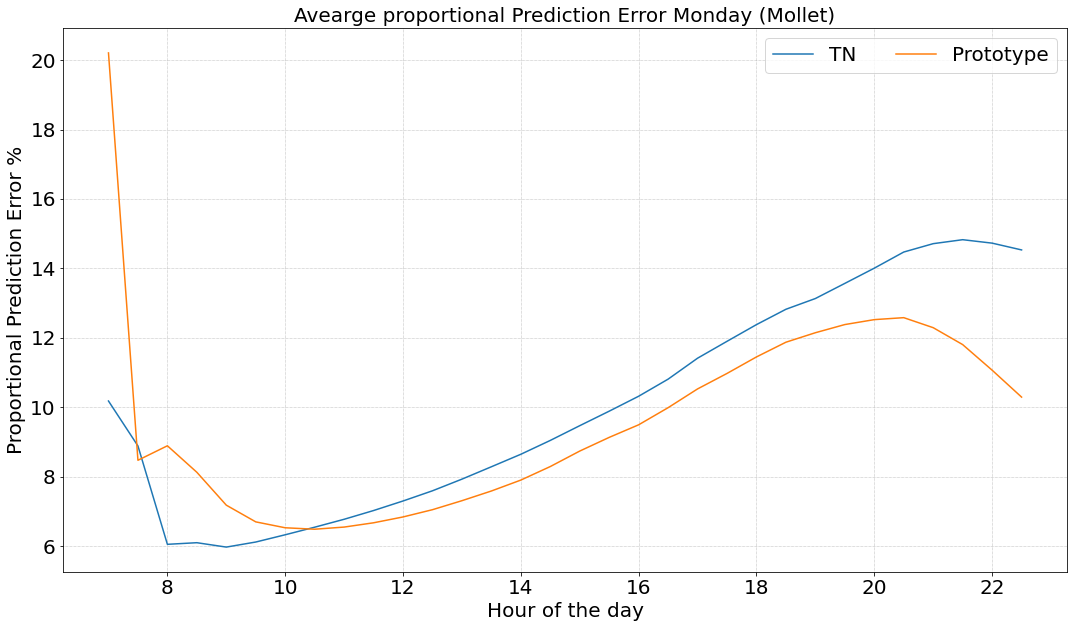

In [47]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [48]:
proto_running_error_wd=proto_running_error_vec
tn_running_error_wd=tn_running_error_vec

#### TUESDAY

In [49]:
statistic_proto = hist_weekday_proto
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 7.5
day = 'Tuesday'

In [50]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday

2020-02-25


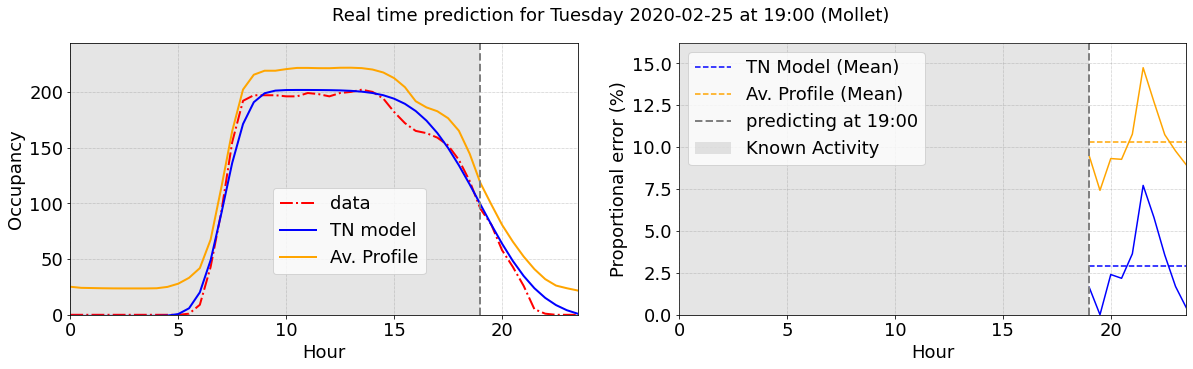

In [51]:
limit_hour = 19
fsize=18

if isinstance(limit_hour, int):
    hourstring = str(limit_hour) + ':00'
else:
    hourstring = str(int(limit_hour))+':'+str(int((limit_hour-int(limit_hour))*60))

for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
i=0

t_date=t_dates[cont]
print(t_date)
#tn_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_proto, max_value)
tn_arr_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_arr_proto)
stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

#scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]

scaled_tn_arr_proto_uncut=scaled_tn_arr_proto.copy()

if max(scaled_tn_arr_proto)>max_value:
    cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
    print(round(cars_could_not_park), "cars could not park")
    scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
    scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
else: 
    cars_could_not_park=0
    
scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

#scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
scaled_stat_proto = statistic_proto.values 
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(5)
axx=0;
time = np.linspace(0,23.5,48)
fig.suptitle('Real time prediction for '
             + day + ' ' +t_date + ' at '+ hourstring +' ('+ current_parking+')', fontsize=fsize)
ax[axx].plot(time, t_days[i].values, linestyle='dashdot', color='red', linewidth=2, label='data')
#ax[axx].plot(time, tn_proto,'--',color='grey', label='TN prototype (not scaled)')
if cars_could_not_park>0:
    ax[axx].plot(time, scaled_tn_arr_proto_uncut, color='black', linewidth=2, 
             label='excess: '+str(round(cars_could_not_park)) + ' cars')
ax[axx].plot(time, scaled_tn_proto2, color='blue', linewidth=2, label='TN model')
ax[axx].plot(time, scaled_stat_proto, color='orange', linewidth=2, label='Av. Profile')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2)
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].set_ylim([0,1.1*max([max(t_days[i].values),max(tn_proto),max(scaled_tn_proto2),
                             max(scaled_stat_proto),max(scaled_tn_arr_proto_uncut)])])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_xlim([0,23.5])
ax[axx].set_ylabel('Occupancy', fontsize=fsize)
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)
ax[axx].legend(fontsize=fsize,loc="best", bbox_to_anchor=(0.55,0.5))

#
axx=1;

limit_hourIdx = int(limit_hour*2)
tn_scaled_error = (np.absolute((np.array(scaled_tn_proto2) - np.array(t_days[i].values)))/max_value)*100
mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/max_value)*100

#tn_scaled_error = (np.absolute((np.array(scaled_tn_proto2) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100
#mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100

tn_s_error_mean = [np.mean(tn_scaled_error[limit_hourIdx:])]*len(tn_scaled_error)
mean_s_error_mean = [np.mean(mean_scaled_error[limit_hourIdx:])]*len(mean_scaled_error)

#Second plot
#     time = time[limit_hour:]
ax[axx].plot(time[limit_hourIdx:], tn_scaled_error[limit_hourIdx:], color='blue') #, label='TN Model')
ax[axx].plot(time[limit_hourIdx:],tn_s_error_mean[limit_hourIdx:], '--',color='blue', label='TN Model (Mean)')
ax[axx].plot(time[limit_hourIdx:],mean_scaled_error[limit_hourIdx:], color='orange')#, label='Average Profile')
ax[axx].plot(time[limit_hourIdx:],mean_s_error_mean[limit_hourIdx:], '--',color='orange', label='Av. Profile (Mean)')
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='predicting at '+ hourstring)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2, zorder=4, label='Known Activity')
ax[axx].set_xlim([0,23.5])
ax[axx].legend(fontsize=fsize)
ax[axx].set_ylim([0,1.1*max(max(tn_scaled_error[limit_hourIdx:]),max(mean_scaled_error[limit_hourIdx:]))])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_ylabel('Proportional error (%)', fontsize=fsize);
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)

fig.savefig('ExamplePrediction_'+current_parking+'TH_'+hourstring.replace(':','h') +'.pdf',bbox_inches='tight');

2020-02-25
Real Tuesday scaled prototype error:  1.43 %
Real Tuesday scaled prototype error (median):  0.81 %
Real Tuesday scaled prototype STDV: 1.2521869904205687
Real Tuesday scaled TN error:  2.91 %
Real Tuesday scaled TN error (median):  2.29 %
Real Tuesday scaled TN STDV:  2.259126776346773
_____________________________________________________________
2020-03-03
23 cars could not park
Real Tuesday scaled prototype error:  2.14 %
Real Tuesday scaled prototype error (median):  1.85 %
Real Tuesday scaled prototype STDV: 1.1150060990318318
Real Tuesday scaled TN error:  0.81 %
Real Tuesday scaled TN error (median):  0.44 %
Real Tuesday scaled TN STDV:  0.8114163658737128
_____________________________________________________________
2020-03-10
44 cars could not park
Real Tuesday scaled prototype error:  7.24 %
Real Tuesday scaled prototype error (median):  8.03 %
Real Tuesday scaled prototype STDV: 2.068507158034496
Real Tuesday scaled TN error:  7.98 %
Real Tuesday scaled TN error (m

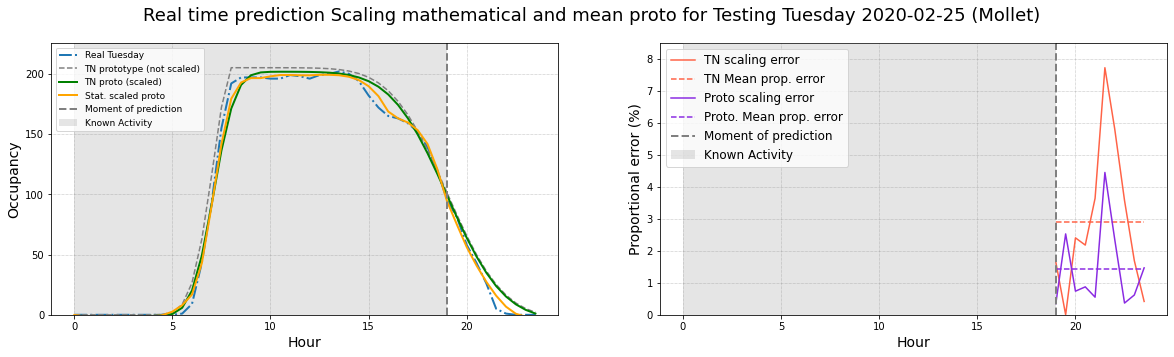

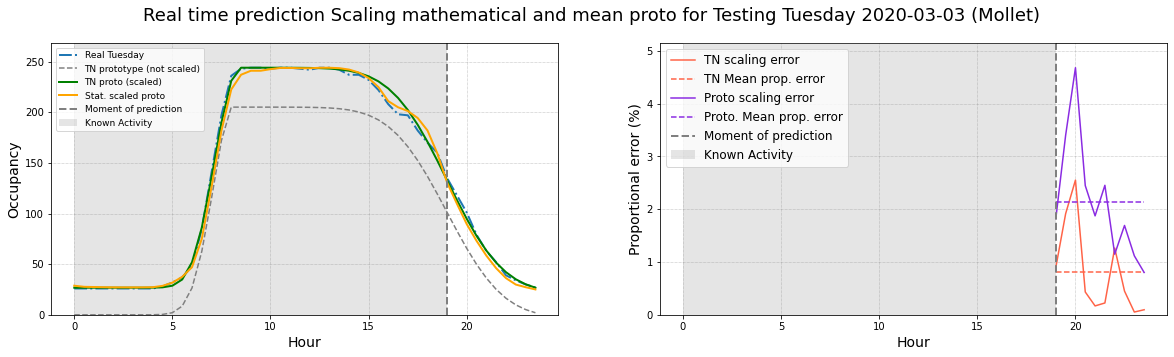

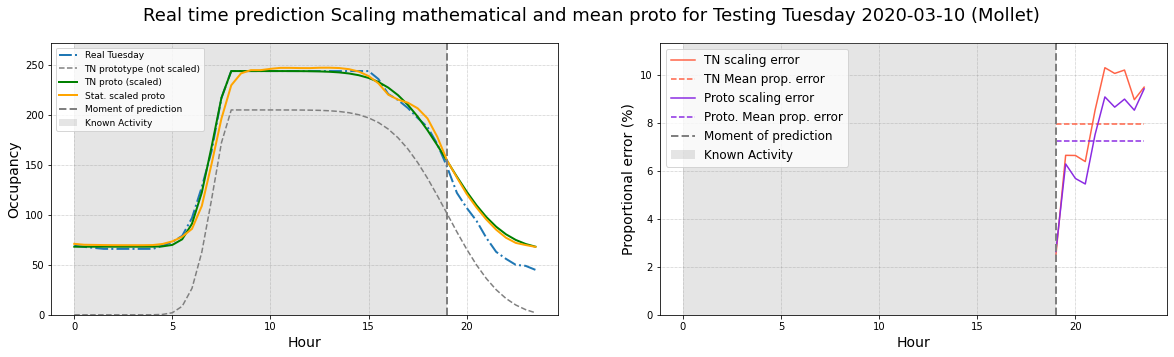

In [52]:

plot_prototype_fitTH()

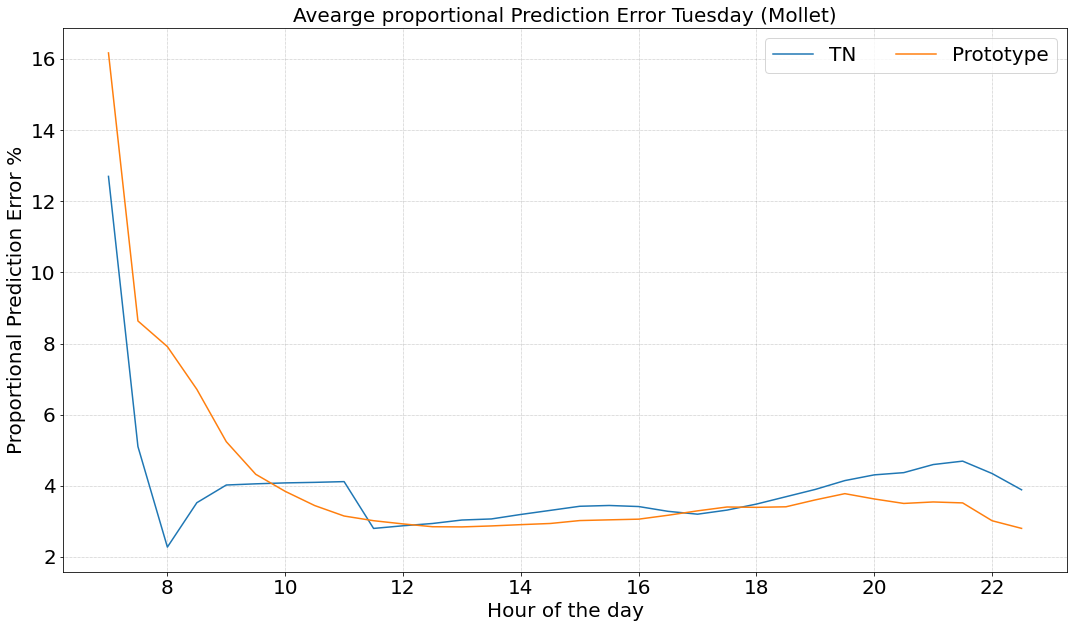

In [53]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [54]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

### WEDNESDAY

In [55]:
statistic_proto = hist_weekday_proto
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 7
day = 'Wednesday'

2020-02-26
Real Wednesday scaled prototype error:  8.38 %
Real Wednesday scaled prototype error (median):  9.47 %
Real Wednesday scaled prototype STDV: 4.026021386278001
Real Wednesday scaled TN error:  36.84 %
Real Wednesday scaled TN error (median):  42.13 %
Real Wednesday scaled TN STDV:  19.469061616262096
_____________________________________________________________
2020-03-04
3 cars could not park
Real Wednesday scaled prototype error:  11.42 %
Real Wednesday scaled prototype error (median):  13.21 %
Real Wednesday scaled prototype STDV: 4.689332264648264
Real Wednesday scaled TN error:  3.9 %
Real Wednesday scaled TN error (median):  4.37 %
Real Wednesday scaled TN STDV:  3.2318138359794997
_____________________________________________________________
2020-03-11
Real Wednesday scaled prototype error:  2.66 %
Real Wednesday scaled prototype error (median):  2.52 %
Real Wednesday scaled prototype STDV: 1.6511466063950346
Real Wednesday scaled TN error:  7.67 %
Real Wednesday scale

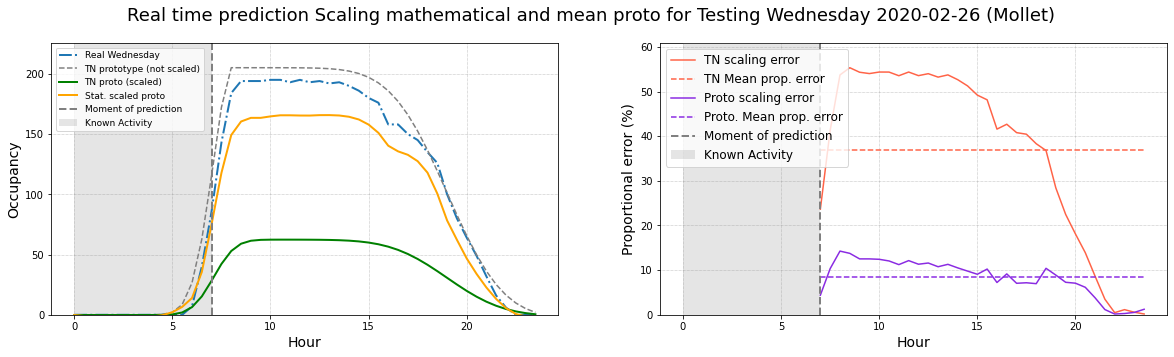

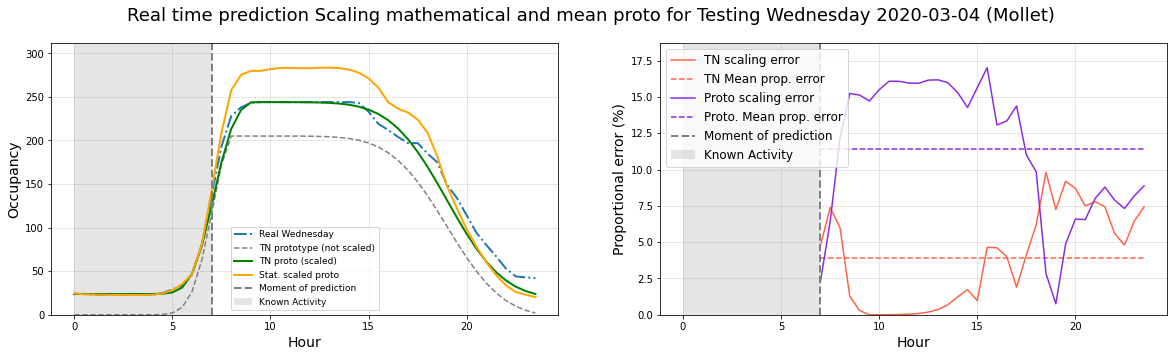

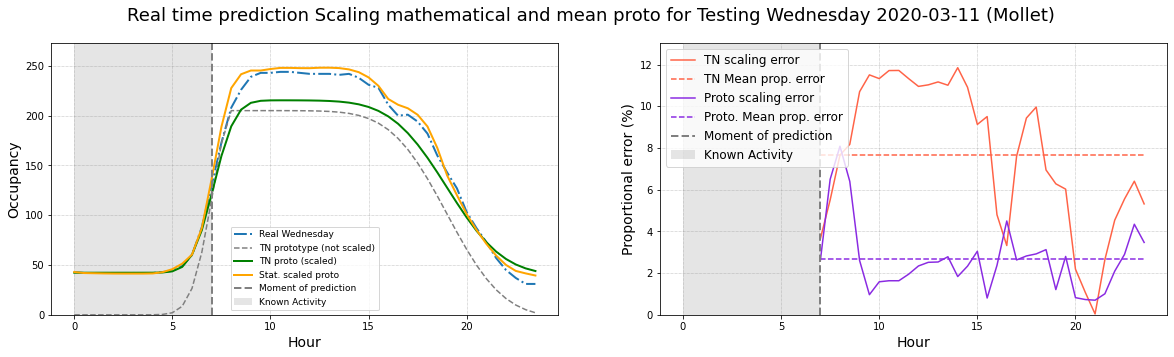

In [56]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

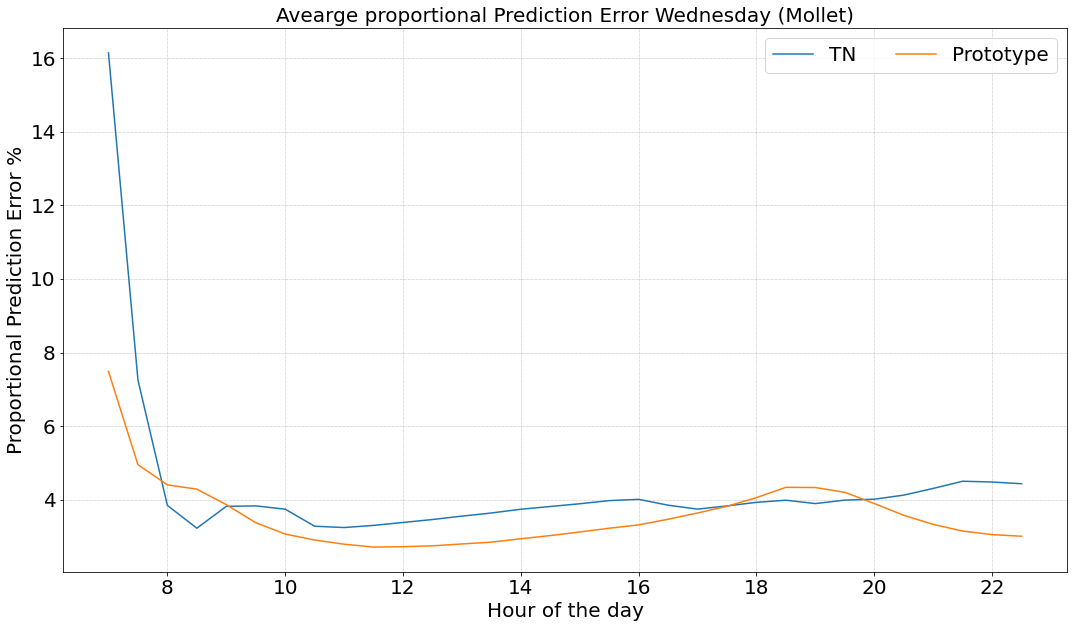

In [57]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [58]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

### THURSDAY

In [59]:
statistic_proto = hist_weekday_proto
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 7
day = 'Thursday'

2020-02-27
Real Thursday scaled prototype error:  11.04 %
Real Thursday scaled prototype error (median):  12.3 %
Real Thursday scaled prototype STDV: 4.342126524552458
Real Thursday scaled TN error:  32.1 %
Real Thursday scaled TN error (median):  38.46 %
Real Thursday scaled TN STDV:  15.760326377750095
_____________________________________________________________
2020-03-05
22 cars could not park
Real Thursday scaled prototype error:  11.63 %
Real Thursday scaled prototype error (median):  14.17 %
Real Thursday scaled prototype STDV: 5.549916158008136
Real Thursday scaled TN error:  2.67 %
Real Thursday scaled TN error (median):  2.64 %
Real Thursday scaled TN STDV:  2.539509574278405
_____________________________________________________________
2020-03-12
9 cars could not park
Real Thursday scaled prototype error:  8.78 %
Real Thursday scaled prototype error (median):  9.01 %
Real Thursday scaled prototype STDV: 4.599641902748228
Real Thursday scaled TN error:  2.92 %
Real Thursday 

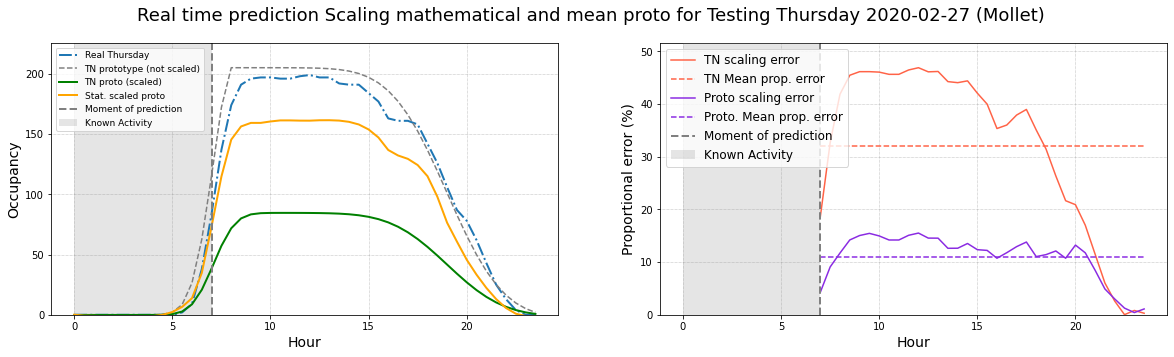

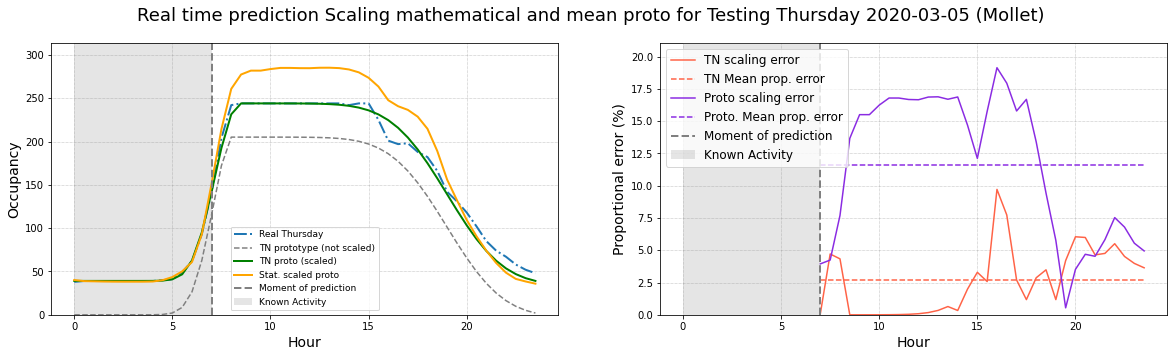

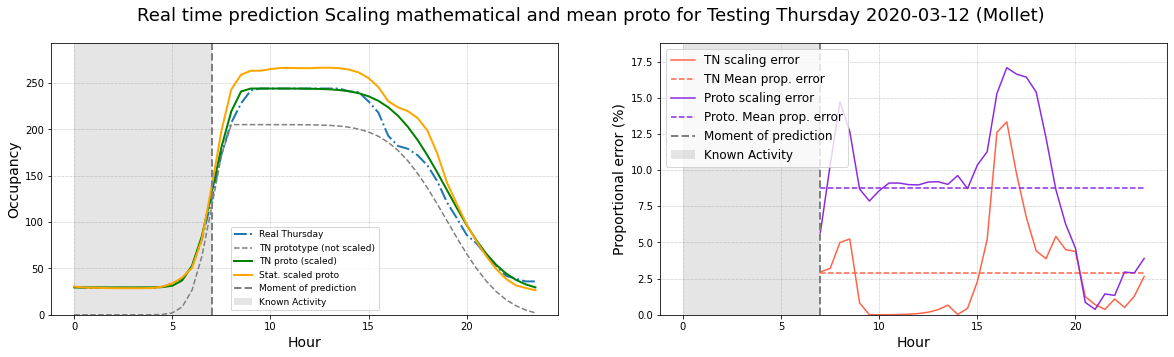

In [60]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

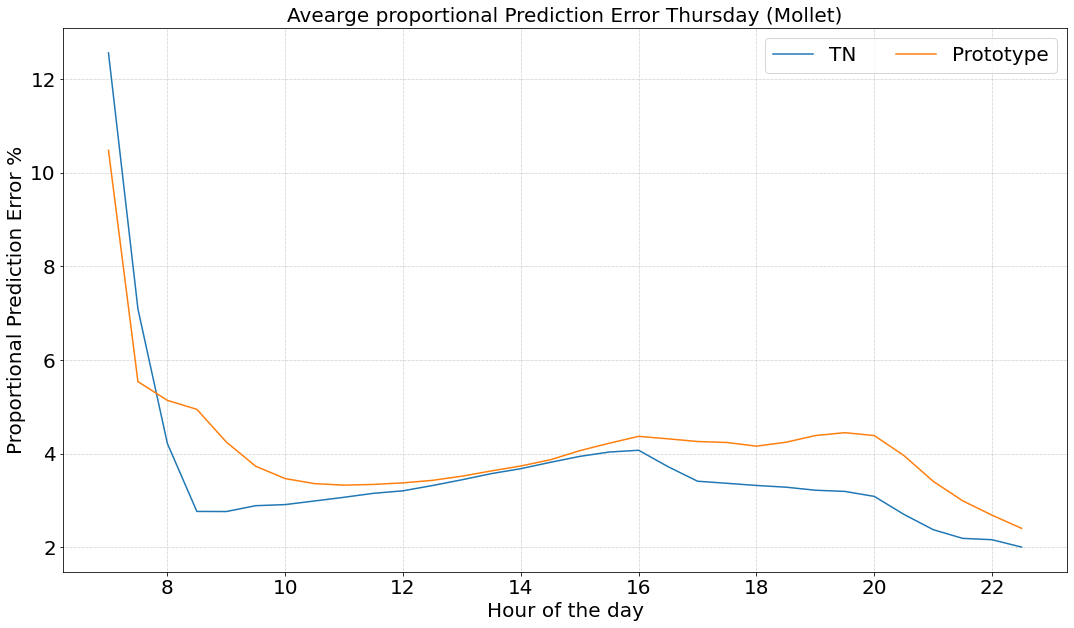

In [61]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [62]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

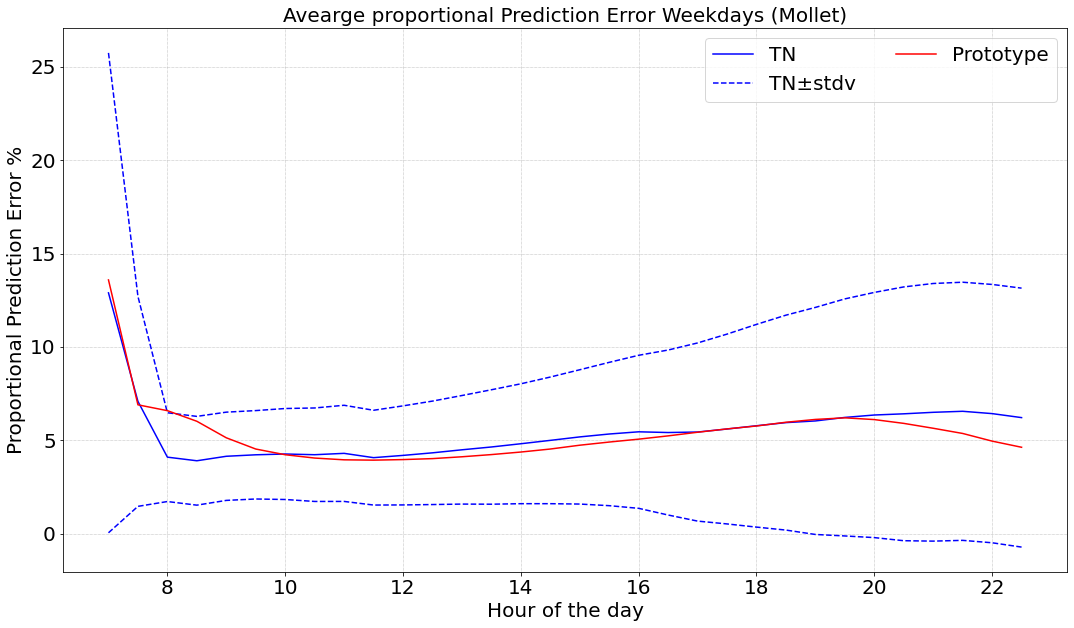

In [63]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_wd,proto_running_error_wd,starting_hour,"Weekdays",current_parking)

### FRIDAY

In [64]:
statistic_proto = hist_friday_proto
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'

2020-02-28
20 cars could not park
Real Friday scaled prototype error:  2.15 %
Real Friday scaled prototype error (median):  2.13 %
Real Friday scaled prototype STDV: 0.9762827476990465
Real Friday scaled TN error:  9.07 %
Real Friday scaled TN error (median):  10.21 %
Real Friday scaled TN STDV:  5.49591570580676
_____________________________________________________________
2020-03-06
29 cars could not park
Real Friday scaled prototype error:  14.46 %
Real Friday scaled prototype error (median):  14.03 %
Real Friday scaled prototype STDV: 2.415245290843113
Real Friday scaled TN error:  9.31 %
Real Friday scaled TN error (median):  8.38 %
Real Friday scaled TN STDV:  3.919140343994685
_____________________________________________________________
2020-03-13
Real Friday scaled prototype error:  19.88 %
Real Friday scaled prototype error (median):  20.91 %
Real Friday scaled prototype STDV: 2.174794971353397
Real Friday scaled TN error:  19.06 %
Real Friday scaled TN error (median):  19.33

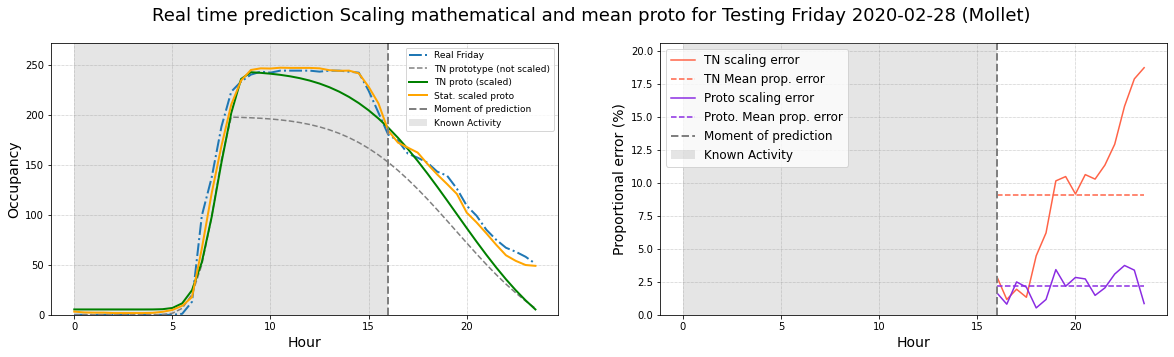

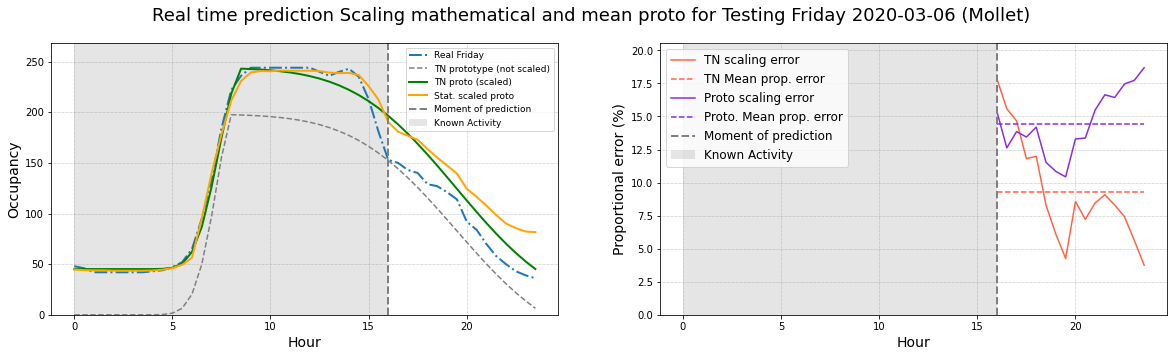

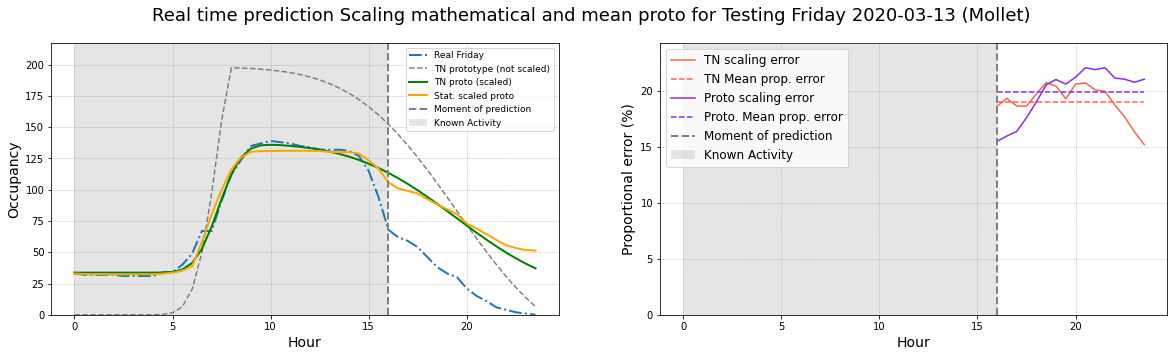

In [65]:
tn_proto = tn_friday_nooff

tn_arr_proto = tn_arr_friday_nooff
tn_dep_proto = tn_dep_friday
plot_prototype_fitTH()

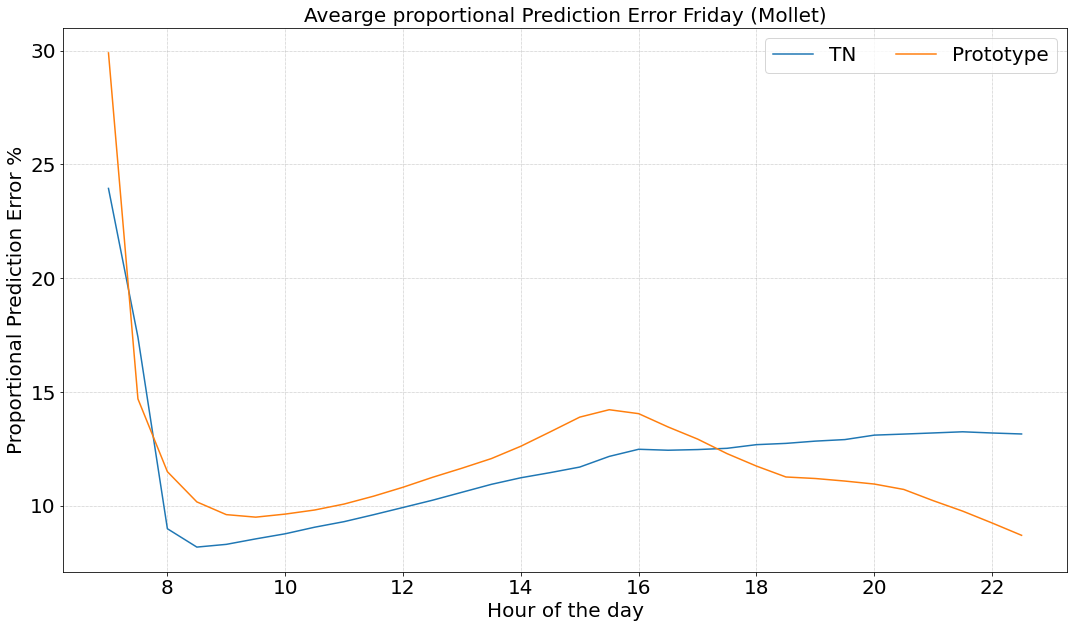

In [66]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [67]:
proto_running_error_fr=proto_running_error_vec
tn_running_error_fr=tn_running_error_vec

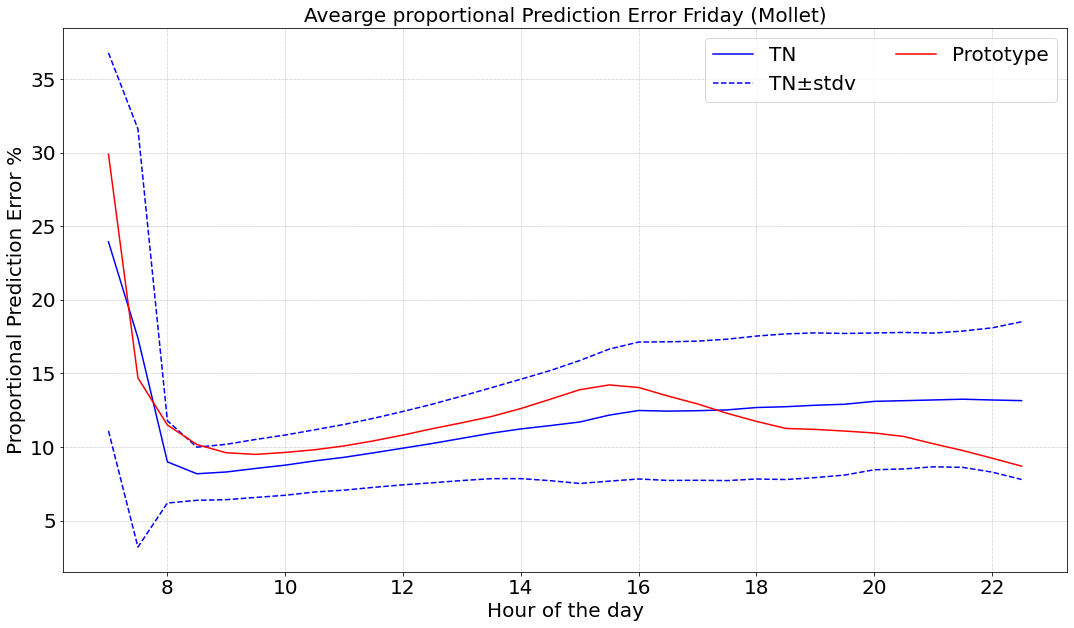

In [68]:

figH=plotRunningPredcitionErrorSTDV(tn_running_error_fr,proto_running_error_fr,starting_hour,day,current_parking)

### WEEKEND

### SATURDAY

In [69]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-29
Real Saturday scaled prototype error:  2.39 %
Real Saturday scaled prototype error (median):  1.92 %
Real Saturday scaled prototype STDV: 1.5174121348169725
Real Saturday scaled TN error:  1.71 %
Real Saturday scaled TN error (median):  1.33 %
Real Saturday scaled TN STDV:  1.2777288606718835
_____________________________________________________________
2020-03-07
Real Saturday scaled prototype error:  3.17 %
Real Saturday scaled prototype error (median):  2.33 %
Real Saturday scaled prototype STDV: 2.6588656610806902
Real Saturday scaled TN error:  1.86 %
Real Saturday scaled TN error (median):  1.55 %
Real Saturday scaled TN STDV:  1.2255986884086354
_____________________________________________________________
2020-03-14
Real Saturday scaled prototype error:  2.46 %
Real Saturday scaled prototype error (median):  2.35 %
Real Saturday scaled prototype STDV: 1.2578046950463573
Real Saturday scaled TN error:  2.05 %
Real Saturday scaled TN error (median):  2.33 %
Real Saturd

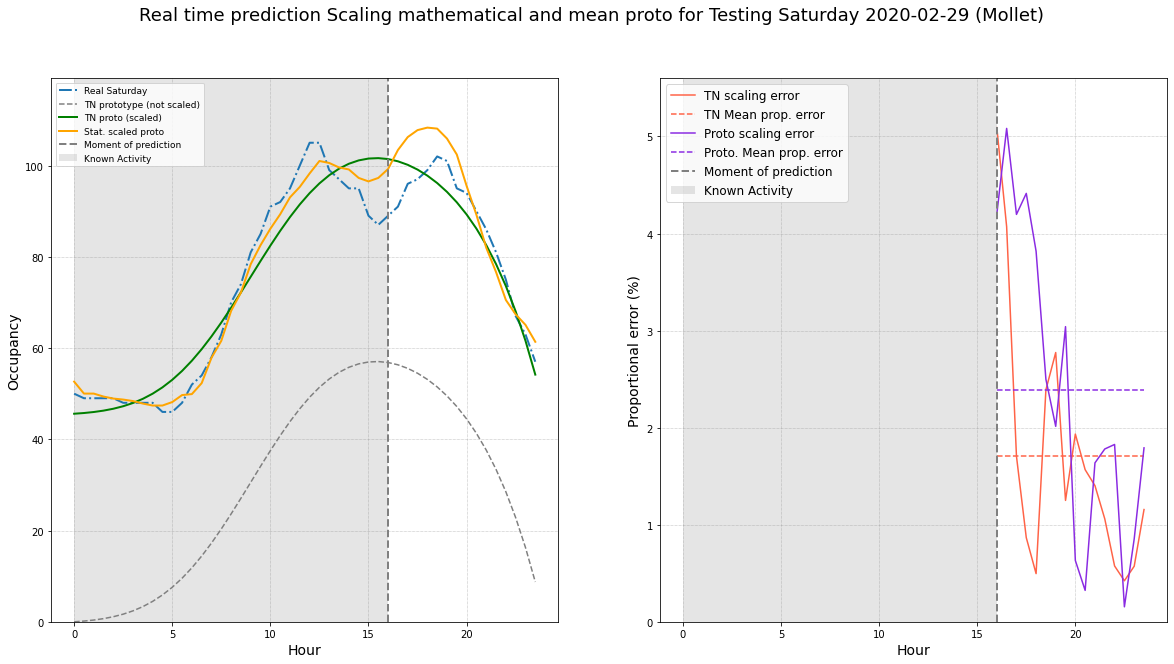

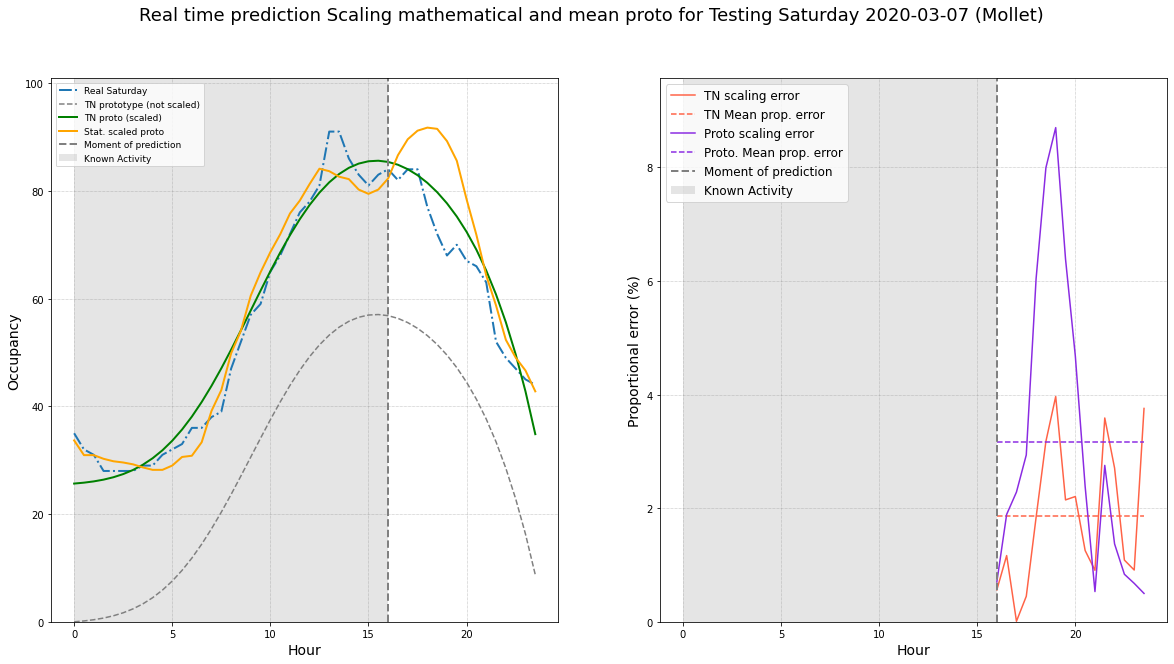

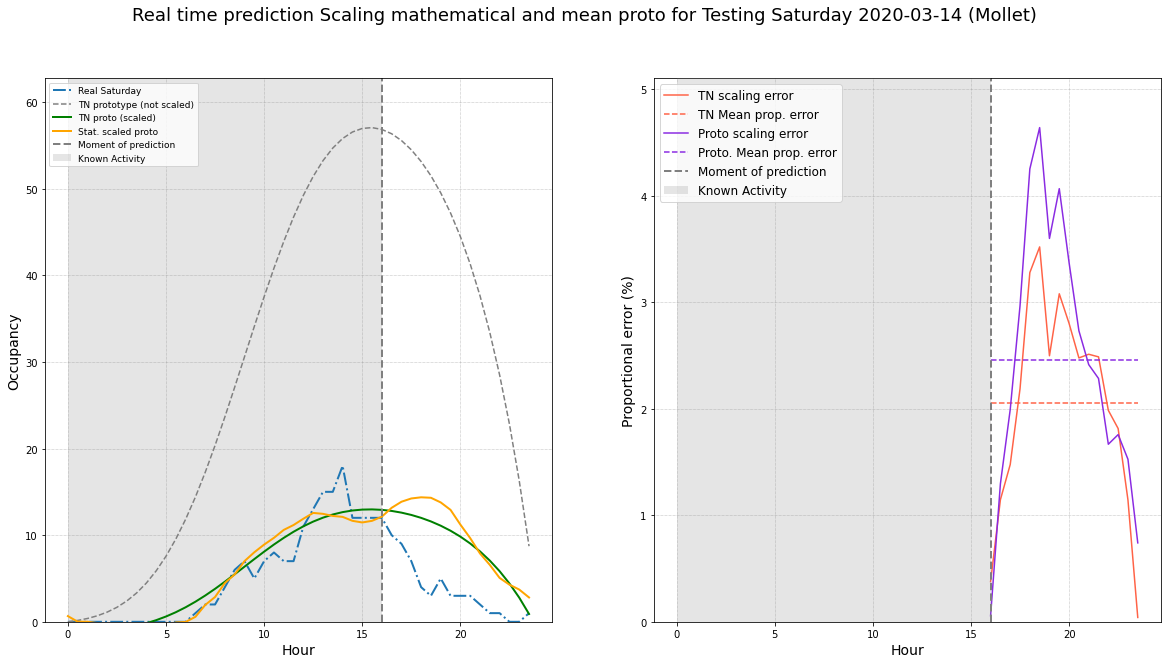

In [70]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

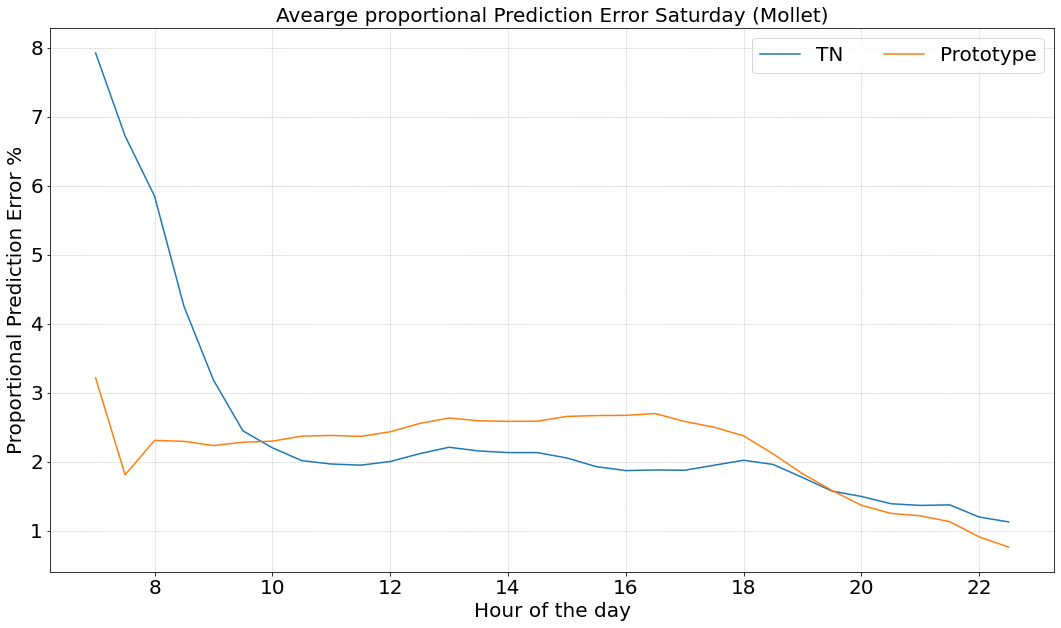

In [71]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [72]:
proto_running_error_we=proto_running_error_vec
tn_running_error_we=tn_running_error_vec

2020-02-29
Real Saturday scaled prototype error:  1.92 %
Real Saturday scaled prototype error (median):  1.32 %
Real Saturday scaled prototype STDV: 1.4145536000335286
Real Saturday scaled TN error:  4.66 %
Real Saturday scaled TN error (median):  4.89 %
Real Saturday scaled TN STDV:  1.9988131124205344
_____________________________________________________________
2020-03-07
Real Saturday scaled prototype error:  4.8 %
Real Saturday scaled prototype error (median):  5.56 %
Real Saturday scaled prototype STDV: 2.184637985997603
Real Saturday scaled TN error:  2.21 %
Real Saturday scaled TN error (median):  2.07 %
Real Saturday scaled TN STDV:  1.5346401362003017
_____________________________________________________________
2020-03-14
Real Saturday scaled prototype error:  2.9 %
Real Saturday scaled prototype error (median):  3.31 %
Real Saturday scaled prototype STDV: 1.0890454975706614
Real Saturday scaled TN error:  2.51 %
Real Saturday scaled TN error (median):  3.01 %
Real Saturday 

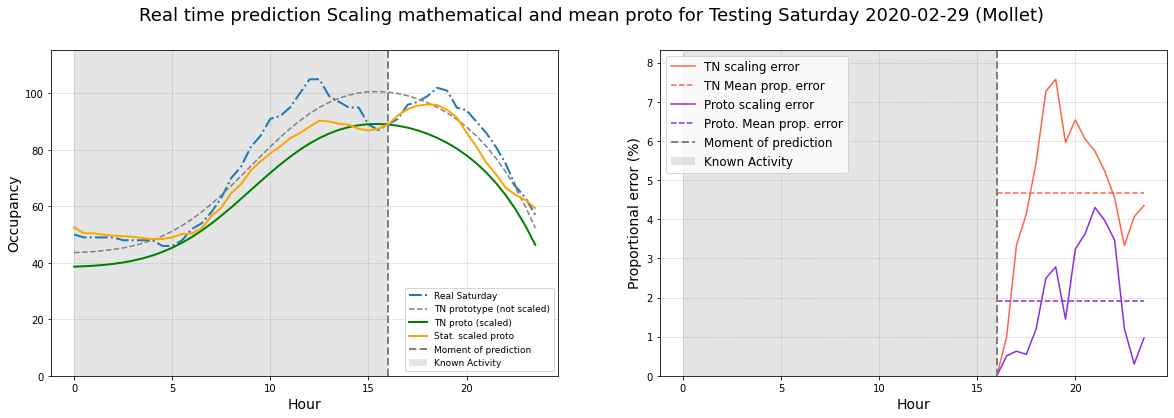

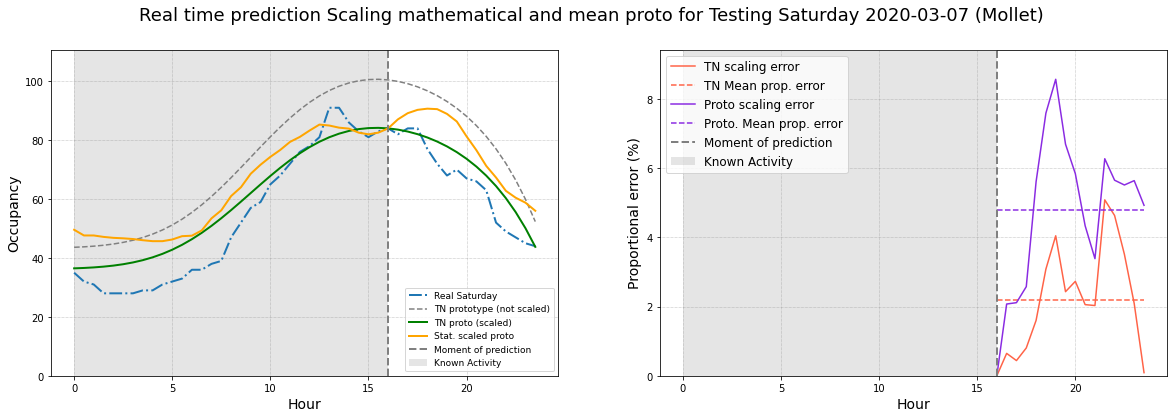

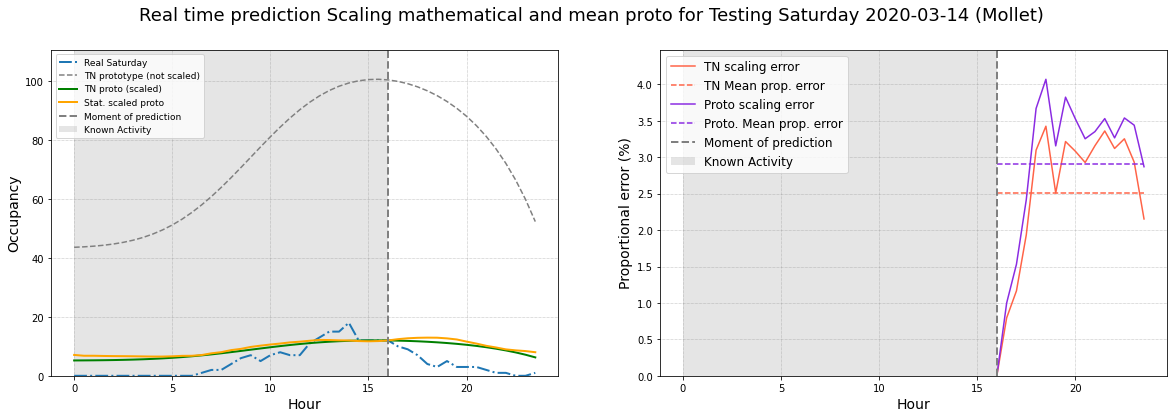

In [73]:
tn_proto = tn1_weekend   
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

In [74]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-03-01
Real Sunday scaled prototype error:  2.79 %
Real Sunday scaled prototype error (median):  2.77 %
Real Sunday scaled prototype STDV: 1.5283547838953098
Real Sunday scaled TN error:  2.61 %
Real Sunday scaled TN error (median):  2.5 %
Real Sunday scaled TN STDV:  1.6729296379806793
_____________________________________________________________
2020-03-08
Real Sunday scaled prototype error:  6.57 %
Real Sunday scaled prototype error (median):  5.71 %
Real Sunday scaled prototype STDV: 5.10454055650916
Real Sunday scaled TN error:  6.55 %
Real Sunday scaled TN error (median):  4.67 %
Real Sunday scaled TN STDV:  5.409190927799894
_____________________________________________________________
2020-03-15
Real Sunday scaled prototype error:  0.57 %
Real Sunday scaled prototype error (median):  0.45 %
Real Sunday scaled prototype STDV: 0.4101311561842751
Real Sunday scaled TN error:  0.46 %
Real Sunday scaled TN error (median):  0.41 %
Real Sunday scaled TN STDV:  0.3329279605373561
_

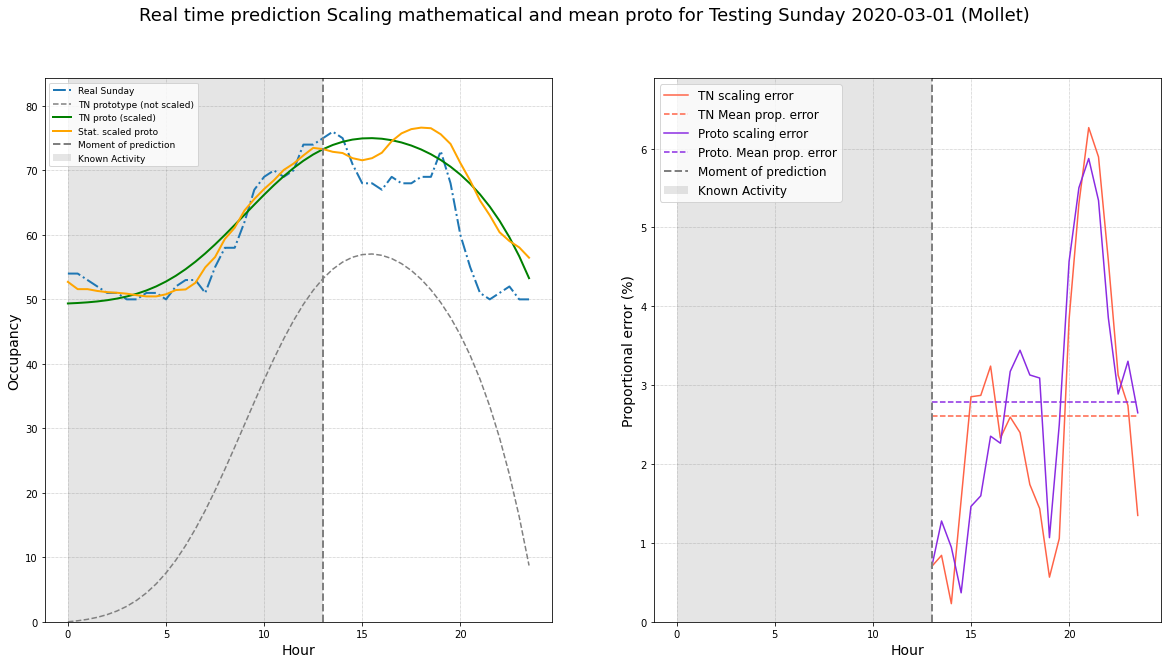

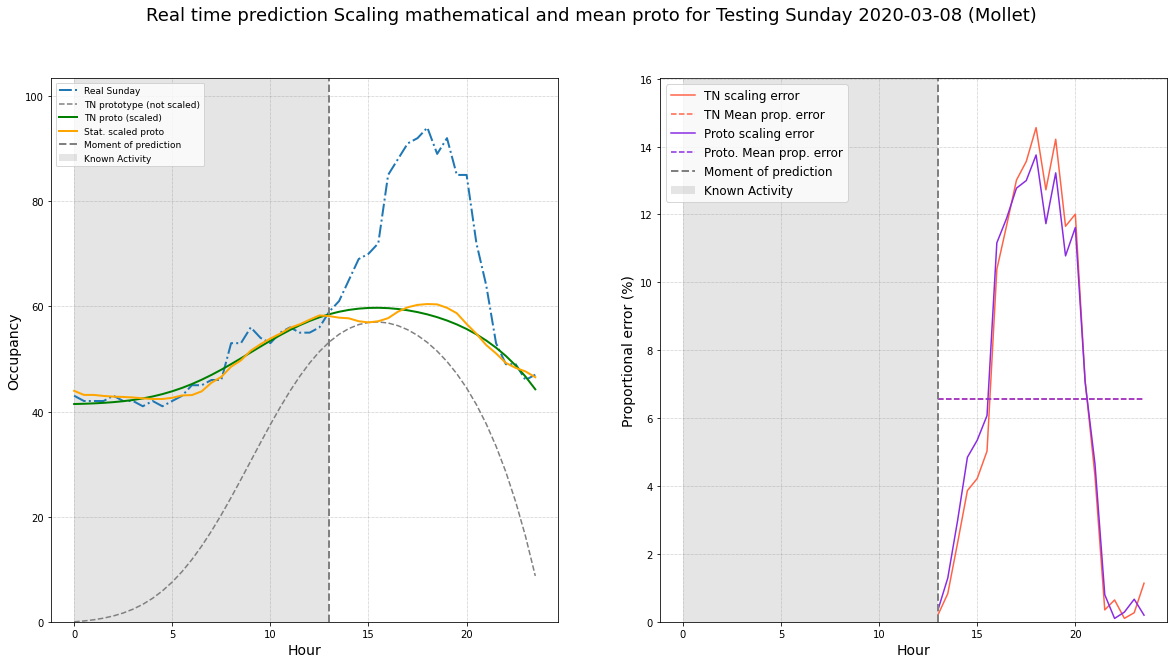

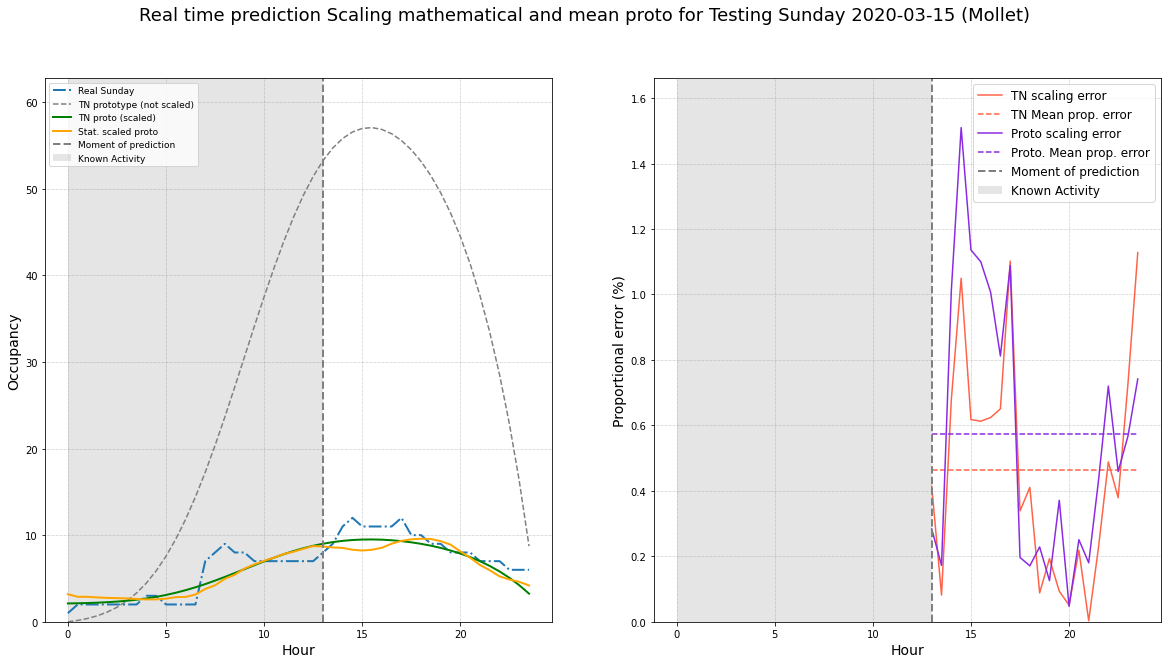

In [75]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

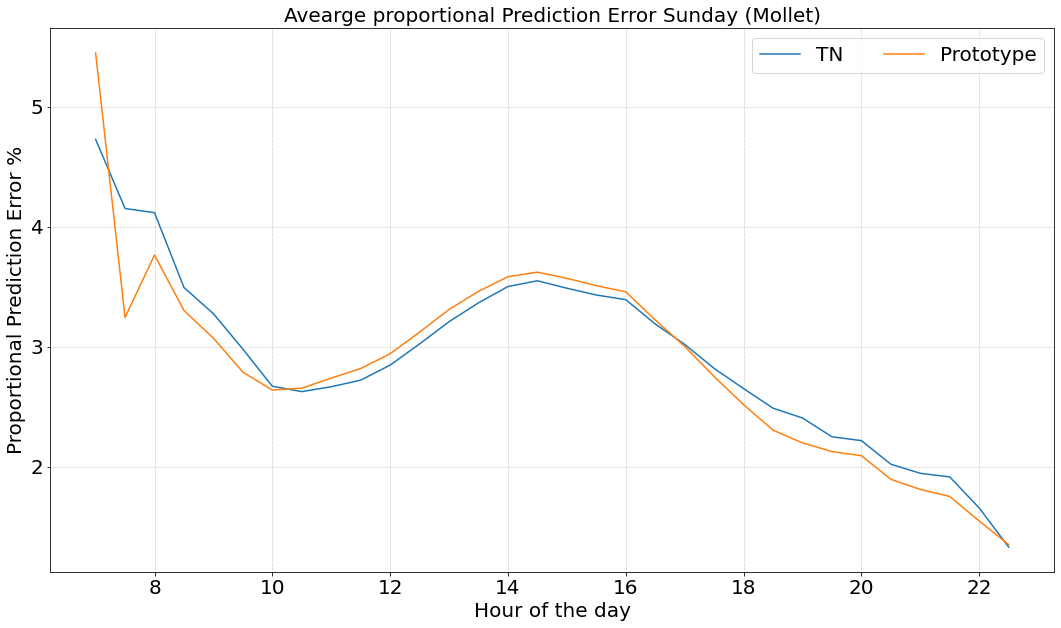

In [76]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [77]:
proto_running_error_we=np.concatenate((proto_running_error_we, proto_running_error_vec), axis=1)
tn_running_error_we=np.concatenate((tn_running_error_we, tn_running_error_vec), axis=1)

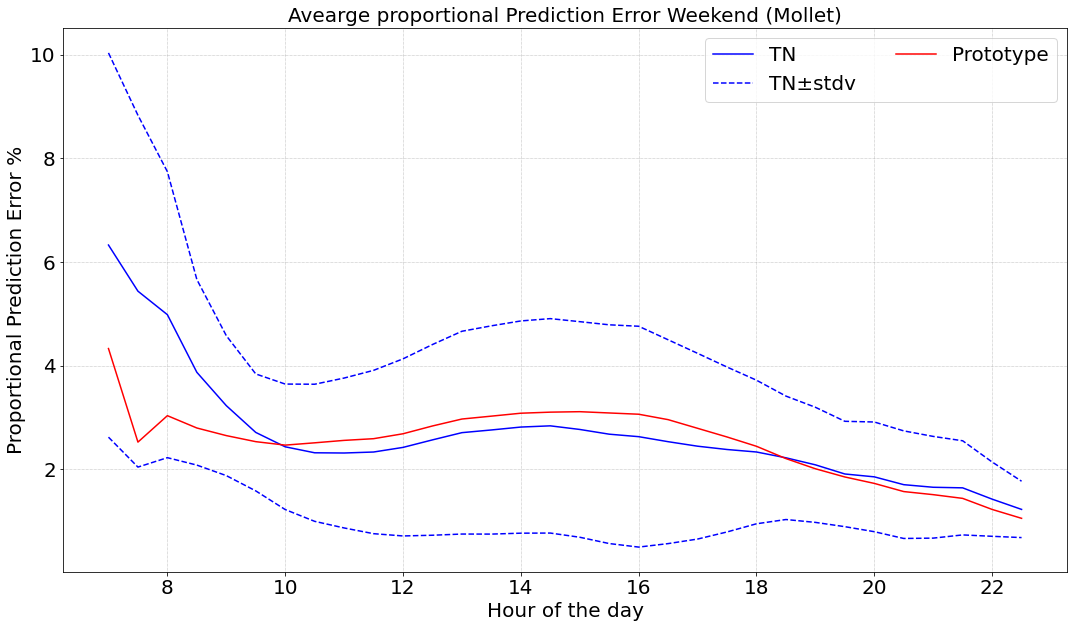

In [78]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_we,proto_running_error_we,starting_hour,"Weekend",current_parking)

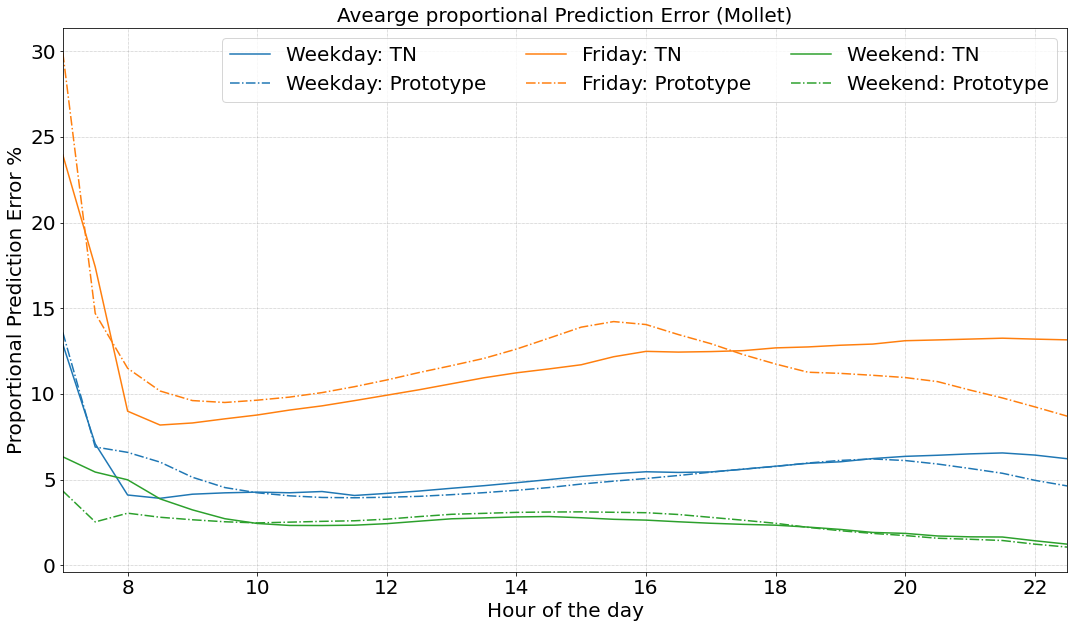

In [79]:
figH=plotRunningPredcitionErrorAgg(tn_running_error_wd,proto_running_error_wd,tn_running_error_fr,
                                  proto_running_error_fr,tn_running_error_we,proto_running_error_we,
                                  starting_hour,current_parking,False)
figH.savefig('RunningPredictionError_'+current_parking+'TH.pdf',bbox_inches='tight');

## Running  Prediction

In [80]:
day_indexes = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tn_proto_dict={}
tn_proto_dict["Monday"] = tn_weekday_nooff
tn_proto_dict["Tuesday"] = tn_weekday_nooff
tn_proto_dict["Wednesday"] = tn_weekday_nooff
tn_proto_dict["Thursday"] = tn_weekday_nooff
tn_proto_dict["Friday"] = tn_friday_nooff
tn_proto_dict["Saturday"] = tn1_weekend_nooff
tn_proto_dict["Sunday"] = tn1_weekend_nooff

tn_arr_proto_dict={}
tn_arr_proto_dict["Monday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Tuesday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Wednesday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Thursday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Friday"] = tn_arr_friday_nooff


tn_dep_proto_dict={}
tn_dep_proto_dict["Monday"] = tn_dep_weekday
tn_dep_proto_dict["Tuesday"] = tn_dep_weekday
tn_dep_proto_dict["Wednesday"] = tn_dep_weekday
tn_dep_proto_dict["Thursday"] = tn_dep_weekday
tn_dep_proto_dict["Friday"] = tn_dep_friday


t_days_dict={}
t_days_dict["Monday"] = testing_mondays
t_days_dict["Tuesday"] = testing_tuesdays
t_days_dict["Wednesday"] = testing_wednesdays
t_days_dict["Thursday"] = testing_thursdays
t_days_dict["Friday"] = testing_fridays
t_days_dict["Saturday"] = testing_saturdays
t_days_dict["Sunday"] = testing_sundays

hist_proto_dict={}
hist_proto_dict["Monday"] = hist_weekday_proto
hist_proto_dict["Tuesday"] = hist_weekday_proto
hist_proto_dict["Wednesday"] = hist_weekday_proto
hist_proto_dict["Thursday"] = hist_weekday_proto
hist_proto_dict["Friday"] = hist_friday_proto
hist_proto_dict["Saturday"] = hist_weekend_proto
hist_proto_dict["Sunday"] = hist_weekend_proto

#predWindow_vec=[0.5, 1, 1.5, 2, 2.5, 3] 
predWindow_vec=[1, 2, 3] 

pred_error_array=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])

starting_hour=7
for i in range(0,len(day_indexes)):
    day=day_indexes[i]
    tn_proto=tn_proto_dict[day]
    t_days=t_days_dict[day]
    hist_proto=hist_proto_dict[day]
    j=0
    for pred_window in predWindow_vec:
        if day not in ['Saturday','Sunday']:
            
            tn_arr_proto = tn_arr_proto_dict[day]
            tn_dep_proto = tn_dep_proto_dict[day]
            [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNowTHv2(t_days,hist_proto,
                                                                            tn_arr_proto,tn_dep_proto,max_value,
                                                                            starting_hour,pred_window)
        else:
            [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_proto,
                                                                              tn_proto,max_value,starting_hour,pred_window)
        pred_error_array[j,i]=np.mean(tn_running_error_vec_now)
        pred_error_array_proto[j,i]=np.mean(proto_running_error_vec_now)
        pred_error_array_stdv[j,i]=np.std(tn_running_error_vec_now)
        pred_error_array_proto_stdv[j,i]=np.std(tn_running_error_vec_now)
        
        j=j+1
        #plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

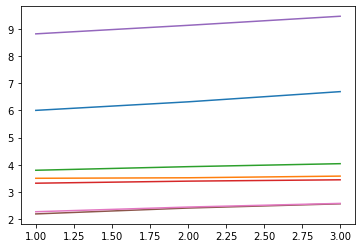

In [81]:
plt.plot(predWindow_vec,pred_error_array)


In [82]:
m_row_runPred=[current_parking,'meanE_tn'] + pred_error_array[0,].tolist()
s_row_runPred=[current_parking,'mStdvE_tn'] + pred_error_array_stdv[0,].tolist()
m_row_runPred_proto=[current_parking,'meanE_proto'] + pred_error_array_proto[0,].tolist()
s_row_runPred_proto=[current_parking,'mStdvE_proto'] + pred_error_array_proto_stdv[0,].tolist()



In [83]:
f = open('data/'+current_parking+'_runnError_1hTH.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row_runPred)
writer.writerow(s_row_runPred)
writer.writerow(m_row_runPred_proto)
writer.writerow(s_row_runPred_proto)

# close the file
f.close()